In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing all the necessary Packages and Libraries

## Installations

In [2]:
pip install BioPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install propy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install pyfaidx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install matplotlib==3.1.1

In [22]:
# pip install dtale

## Imports for peptide feature extraction

In [5]:
# Compute protein descriptors
from propy import PyPro
from propy import AAComposition
from propy import CTD


# Build Sequence Object
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Read Fasta File
from pyfaidx import Fasta

# Grouping iterable
from itertools import chain

# Return file path
import glob

/usr/local/lib/python3.7/dist-packages/propy/__init__.py:29: UserWarning: Python 3.6 and Python 3.7 might get deprecated. Please participate in the discussion: https://github.com/MartinThoma/propy3/issues/12
  "Python 3.6 and Python 3.7 might get deprecated. "


## Imports for ML

In [7]:
# Import necessary packages

import pandas as pd
import numpy as np
import json 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

In [8]:
# import dtale.app as dtale_app
# dtale_app.USE_COLAB = True

# Importing data and Extracting the Features

Each individual protein have unique structural and functional properties, we use Biopython (a free biological computational tool) ProteinAnalysis library, to extract all the necessary features from the sequences. 

## Feature Extraction function

In [8]:
# Feature Extraction

def ExtractFeaturesFasta(fastafile):
    
    """ The ExtractFeaturesFasta function gets the protein sequence in the Fasta file format. 
     
    The function parse the fasta file, read the sequence as string and extract the peptide features using appropriate packages into the dataframe."""
    
    new_peptides = []
    for file in glob.glob(fastafile):
      new_peptides.append(file)
    
    for f in new_peptides:
        fa = Fasta(f)
        # empty list to save the features
        listing = []
        
        for seq in fa:
            # Make sure the sequence is a string
            s = str(seq)
            
            # replace the unappropriate peptide sequence to A
            s = s.replace('X','A')
            s = s.replace('x','A')
            s = s.replace('U','A')
            s = s.replace('Z','A')
            s = s.replace('B','A')

            # Calculating primary features
            analysed_seq = ProteinAnalysis(s)
            wt = analysed_seq.molecular_weight()
            arm = analysed_seq.aromaticity()
            instab = analysed_seq.instability_index()
            flex = analysed_seq.flexibility()
            pI = analysed_seq.isoelectric_point()

            # create a list for the primary features
            pFeatures = [seq.name, s, len(seq), wt, arm, instab, pI]

            # Get Amino Acid Composition (AAC), Composition Transition Distribution (CTD) and Dipeptide Composition (DPC)
            resultAAC = AAComposition.CalculateAAComposition(s)
            resultCTD = CTD.CalculateCTD(s)
            resultDPC = AAComposition.CalculateDipeptideComposition(s)

            # Collect all the features into lists
            aacFeatures = [j for i,j in resultAAC.items()]
            ctdFeatures = [l for k,l in resultCTD.items()]
            dpcFeatures = [n for m,n in resultDPC.items()]
            listing.append(pFeatures + aacFeatures + ctdFeatures + dpcFeatures)
            
        # Collect feature names
        Pname = ['Name','Seq' ,'SeqLength','Weight','Aromaticity','Instability','IsoelectricPoint']
        AACname = [i for i,j in resultAAC.items()]
        CTDname = [k for k,l in resultCTD.items()]
        DPCname = [m for m,n in resultDPC.items()]
        feature_names  = []
        feature_names.append(Pname+AACname+DPCname+CTDname)
        flatten_list = list(chain.from_iterable(feature_names))

        # create dataframe using all extracted features and the names
        allFeatures = pd.DataFrame(listing, columns = flatten_list)
       

        return allFeatures


In [9]:
negativeDf = ExtractFeaturesFasta('/content/drive/Shareddrives/Interview Prep/proteins/negative.fasta')

print('\n')
print('The shape of the negative peptide dataframe')
print('Number of rows:    ', negativeDf.shape[0])
print('Number of columns: ', negativeDf.shape[1])

negativeDf.head()



The shape of the negative peptide dataframe
Number of rows:     2746
Number of columns:  574


,Name,Seq,SeqLength,Weight,Aromaticity,Instability,IsoelectricPoint,A,R,N,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,sp|A0A0P0VIP0|LRSK7_ORYSJ,MPPRCRRLPLLFILLLAVRPLSAAAASSIAAAPASSYRRISWASNL...,695,74134.0302,0.073381,54.427353,9.501624,11.511,8.058,3.309,...,1.30,0.29,0.14,0.00,0.58,0.43,0.00,0.29,0.58,0.58
1,sp|A0A0P0XII1|CERK1_ORYSJ,MEASTSLLVLVLAAAAFAAGTVTEAAGDGCSAGCDLALASFYVTPN...,624,67067.5347,0.091346,36.497788,5.450882,10.096,3.846,4.968,...,0.80,0.16,0.00,0.00,0.16,0.16,0.64,0.00,1.12,0.96
2,sp|A2ZVI7|CDPK1_ORYSJ,MGNRTSRHHRAAPEQPPPQPKPKPQPQQQQQQWPRPQQPTPPPAAA...,518,58739.0334,0.075290,46.398842,6.054399,8.108,7.336,3.282,...,0.58,0.19,0.00,0.39,0.19,0.00,0.39,0.00,0.00,0.39
3,sp|A3BMZ5|BGL26_ORYSJ,MRKFIAALRLALAAAAHLLLTLPPAQCYWLNPEIYDAGGLSRRAFP...,510,58497.5243,0.156863,30.562176,7.202205,8.824,5.686,5.098,...,0.00,1.18,0.00,0.20,0.39,0.20,0.39,0.20,0.20,0.00
4,sp|B1Q3J6|DNM1B_ORYSJ,MVKSPCSPVTTGKKRCRAKPQKKDEDTTDKGKLDEGPLDATKEMNG...,1529,171906.4665,0.085023,42.373604,5.846368,7.325,5.363,4.447,...,0.20,0.46,0.33,0.20,0.33,0.79,0.13,0.07,0.26,0.39


In [10]:
positiveDf = ExtractFeaturesFasta('/content/drive/Shareddrives/Interview Prep/proteins/positive.fasta')

print('\n')
print('The shape of the negative peptide dataframe')
print('Number of rows:    ', positiveDf.shape[0])
print('Number of columns: ', positiveDf.shape[1])

positiveDf.head()



The shape of the negative peptide dataframe
Number of rows:     448
Number of columns:  574


,Name,Seq,SeqLength,Weight,Aromaticity,Instability,IsoelectricPoint,A,R,N,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,sp|Q15746.4|MYLK_HUMAN,MGDVKLVASSHISKTSLSVDPSRVDSMPLTEAPAFILPPRNLCIKE...,1914,210712.6252,0.059039,46.071583,5.854723,6.844,5.068,3.292,...,0.78,0.42,0.16,0.16,0.21,0.89,0.58,0.10,0.16,0.37
1,sp|Q05655.2|KPCD_HUMAN,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...,676,77504.1833,0.110947,42.472204,7.933624,5.769,4.882,4.290,...,1.33,0.44,0.15,0.00,0.00,0.30,0.44,0.15,0.00,0.15
2,sp|Q09JW6.1|KUNI_ARGMO,MRLLALFAFAVAVVSAQRNQMCQQPRTQGSCDASNQITKFFYTGSG...,144,15351.4655,0.083333,53.282708,4.301143,7.639,4.861,3.472,...,0.00,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
3,sp|P07996.2|TSP1_HUMAN,MGLAWGLGVLFLMHVCGTNRIPESGGDNSVFDIFELTGAARKGSGR...,1170,129381.4157,0.075214,42.026419,4.713794,4.444,5.128,6.923,...,0.34,0.26,0.17,0.60,0.60,0.26,0.60,0.00,0.09,0.60
4,sp|Q7SZN0.1|FA5V_PSETE,MGRYSVSPVPKCLLLMFLGWSGLKYYQVNAAQLREYHIAAQLEDWD...,1460,165930.3940,0.109589,37.376726,5.733713,5.205,3.904,4.658,...,0.41,0.48,0.07,0.55,0.48,0.41,0.27,0.14,0.21,0.27


Add Target column 'Class' for both positive and negative data. Combing positive and negative in a single dataset

In [11]:
# Adding Target column
negativeDf['Class'] = 0
positiveDf['Class'] = 1

# Concatenate both dataframes
peptideDf = pd.concat([negativeDf, positiveDf])

# Shuffling the dataframes
peptideDf = peptideDf.sample(frac=1, random_state=1)
peptideDf.head()

,Name,Seq,SeqLength,Weight,Aromaticity,Instability,IsoelectricPoint,A,R,N,...,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100,Class
121,XP_042836648.1angiopoietin-4[Pantheratigris],MLPQPAMLLGGLLLAAAAVTAAQRRGQEAAGRRRTHRVQHGQCSYT...,499,55974.4635,0.066132,45.129459,9.093282,9.218,8.818,5.210,...,0.00,0.20,0.40,0.00,0.00,0.20,0.00,0.20,0.20,1
165,sp|P0C1U4|GUN9_ORYSJ,MSMYGRDPWGGPLEICHDSATDDDRSRNLDLDRGALSRTLDETQQS...,619,68367.9981,0.119548,34.687431,9.241301,9.693,5.170,4.523,...,0.16,0.16,0.49,0.16,0.16,0.00,0.32,0.00,0.81,0
1787,tr|Q0DUK4|Q0DUK4_ORYSJ,MAREQALLLTEIVNRGVEPSGPDAGSPTFSVRVRRRLPDFLQSVNL...,542,60108.4515,0.097786,48.080812,9.249940,11.070,8.856,2.768,...,0.00,0.00,0.18,0.00,0.55,0.00,0.55,0.74,0.37,0
103,"pdb|7AHU|EChainE,CoagulationfactorX",IVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQ...,241,27161.7127,0.099585,38.032822,8.519062,5.809,6.224,2.905,...,0.00,0.00,0.00,0.42,0.83,1.25,0.00,0.00,0.42,1
1336,tr|A0A0P0V7L8|A0A0P0V7L8_ORYSJ,FYKLLIDNVEELLPVVYTPTVGEACQKYGSIFSRPQGLYISLKEKG...,469,51409.2436,0.093817,37.129467,6.367297,9.168,3.838,3.838,...,0.64,0.21,0.43,0.21,0.21,0.43,0.00,0.21,1.07,0


In [12]:
classes, freq = np.unique(peptideDf['Class'], return_counts=True)

print(f'The class {classes[0]} contains {freq[0]} samples')
print(f'The class {classes[1]} contains {freq[1]} samples')

print(f'The ratio of negative and positive: {round(freq[0]/freq[1],2)} : {freq[1]/freq[1]}')

The class 0 contains 2746 samples
The class 1 contains 448 samples
The ratio of negative and positive: 6.13 : 1.0


We can see that we have more negatives than the positives. The negatives are 6 times the positives.

# Preprocessing

## Splitting the datasets

In [13]:
y = peptideDf['Class']
X = peptideDf.drop(['Name','Seq','Class'],axis=1)

# Printing the shape of the dataframe
print('Shape of X: ',X.shape[0],X.shape[1])
print('Shape of y: ',y.shape[0])

# Splitting the data
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.20, random_state=1, stratify=y_)

# Printing the shape of each sets
print('\nTraining set:   ',X_train.shape[0])
print('Validation set: ',X_valid.shape[0])
print('Testing set:    ',X_test.shape[0])

Shape of X:  3194 572
Shape of y:  3194

Training set:    2044
Validation set:  511
Testing set:     639


In [14]:
# dtale.show(peptideDf, host='localhost')

Splitting the datasets 
* First we split the datasets into train and test datasets. 
* Second, We again split the train dataset into train and validation datasets.

Reason
* We should keep the test data untouched until we experiment with the validation dataset and decide the best model.

## Normalization

In [108]:
# Preprocessing 

scaler = MinMaxScaler()
scaler.fit(X_)
X_mms =  pd.DataFrame(scaler.transform(X_), index=X_.index, columns=X_.columns)
X_train_mms =  pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid_mms =  pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test_mms = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [16]:
values_train,freq_train = np.unique(y_train, return_counts=True)
print('Training  ', values_train,freq_train)

values_valid,freq_valid = np.unique(y_valid, return_counts=True)
print('Validation',values_valid,freq_valid)

values_test,freq_test = np.unique(y_test, return_counts=True)
print('Testing   ',values_test,freq_test)

Training   [0 1] [1758  286]
Validation [0 1] [439  72]
Testing    [0 1] [549  90]


# Baseline Model

In [ ]:
def modelling(optimized_model, allModel, X_train,y_train,X_valid,y_valid, X_test,y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allModel) to store results 
    for different models, and train, validation and test features and the target as an input.
    
    For each model the function trains the model with train dataset and predict the target for train, test and 
    validation datasets. 
    
    The performance of each dataset is evaluated and added to the dataframe which will be the output for the function"""
    
    # Assign the model and train the data
    model = optimized_model['model']
    model.fit(X_train,y_train)
    
    # Predict the target using trained model
    y_pred_train = model.predict(X_train)    
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    
    # Stat Calculations for the testing set
    accuracy_test = accuracy_score(y_test, y_pred_test)*100
    f1_positive_test = f1_score(y_test, y_pred_test)*100
    f1_negative_test = f1_score(1-y_test, 1-y_pred_test)*100
    mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
    
    # Stat Calculations for the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)*100
    f1_positive_train = f1_score(y_train, y_pred_train)*100
    f1_negative_train = f1_score(1-y_train, 1-y_pred_train)*100
    mcc_train = matthews_corrcoef(y_train, y_pred_train)*100
    
    # Stat Calculations for the Validation set
    accuracy_valid = accuracy_score(y_valid, y_pred_valid)*100
    f1_positive_valid = f1_score(y_valid, y_pred_valid)*100
    f1_negative_valid = f1_score(1-y_valid, 1-y_pred_valid)*100
    mcc_valid = matthews_corrcoef(y_valid, y_pred_valid)*100

    print(optimized_model['name'])

    print(values_train,freq_train)
    plot_confusion_matrix(model, X_train, y_train)
    plt.title('Training')  
    plt.show()

    print(values_valid,freq_valid )
    plot_confusion_matrix(model, X_valid, y_valid)
    plt.title('Validation')  
    plt.show()

    print(values_test,freq_test)
    plot_confusion_matrix(model, X_test, y_test)
    plt.title('Testing')  
    plt.show()
    
    # create new dictionary for the current model and convert it into dataframe
    currentModel = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_train,
                'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 
                'Train MCC Score' : mcc_train,'Validation Accuracy':accuracy_valid,
                'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 
                'Validation MCC Score' : mcc_valid,'Test Accuracy':accuracy_test,'Test F1 Negative' : f1_negative_test, 
                'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test}
    currentModel = pd.DataFrame(currentModel, index=[0])
    
    # Concatenate currentModel dataframe to allModel dataframe
    allModel = pd.concat([allModel,currentModel], ignore_index=True)
    
    return allModel



def kfold_modelling(optimized_model, allKFold, X, y):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allKFold) to store results 
    for different models, and full dataset features and the target as an input.
    
    For each model the function splits the datasets into 10 batches of train and test datasets. Each batches of data
    is then used to train and test the model. The performance of the model is evaluated for each batches and collected in
    a dataframe. The mean of all 10 batches are calculated and stored in a currentKFold dataframe which is then concatenated
    to the main dataframe allKFold."""
    
    # Assign the model and train the data
    model = optimized_model['model']
    # model.fit(X,y)
    
    # Call StratifiedKFold function to split the data
    skf = StratifiedKFold(n_splits=5, random_state=32, shuffle=True)
    
    # Creating empty dictionary to store 10 batches of performance metrics
    tempDf = pd.DataFrame(columns = ['Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score'])
    
    # Using for loop to loop through 10 batches
    for train_index, test_index in skf.split(X,y):
        # Generate train and test sets
        X_train_kfold, X_valid_kfold = X.iloc[train_index], X.iloc[test_index]
        y_train_kfold, y_valid_kfold = y.iloc[train_index], y.iloc[test_index]

        # Model Fitting
        model.fit(X_train_kfold,y_train_kfold)
        
        # Now we make the predictions on both the training and test sets of the model.
        y_pred_train_kfold = model.predict(X_train_kfold)
        y_pred_valid_kfold = model.predict(X_valid_kfold)
        
         # Calculate Accuracy, F1, and MCC Values of the Validation set
        accuracy_valid = accuracy_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_positive_valid = f1_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_negative_valid = f1_score(1-y_valid_kfold, 1-y_pred_valid_kfold)*100
        mcc_valid = matthews_corrcoef(y_valid_kfold, y_pred_valid_kfold)*100

        # Calculate Accuracy, F1, and MCC Values of the training set
        accuracy_train = accuracy_score(y_train_kfold, y_pred_train_kfold)*100
        f1_positive_train = f1_score(y_train_kfold, y_pred_train_kfold)*100
        f1_negative_train = f1_score(1-y_train_kfold, 1-y_pred_train_kfold)*100
        mcc_train = matthews_corrcoef(y_train_kfold, y_pred_train_kfold)*100
        
        # create a dictionary and dataframe to store the metrics of the current batch
        batchDict = {'Train Accuracy':accuracy_train,'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 'Train MCC Score' : mcc_train, 
                 'Validation Accuracy':accuracy_valid,'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 'Validation MCC Score' : mcc_valid}
        batchDf = pd.DataFrame(batchDict, index=[0])
        # Concatenate the current batch metrics to temp dataframe to store all 10 batches metrics
        tempDf = pd.concat([tempDf,batchDf], ignore_index=True)
    
    # Mean values of the Validation set
    accuracy_mean_valid = tempDf['Validation Accuracy'].mean(axis=0)
    f1_positive_mean_valid = tempDf['Validation F1 Positive'].mean(axis=0)
    f1_negative_mean_valid = tempDf['Validation F1 Negative'].mean(axis=0)
    mcc_mean_valid = tempDf['Validation MCC Score'].mean(axis=0)

    # Mean values of the train set
    accuracy_mean_train = tempDf['Train Accuracy'].mean(axis=0)
    f1_positive_mean_train = tempDf['Train F1 Positive'].mean(axis=0)
    f1_negative_mean_train = tempDf['Train F1 Negative'].mean(axis=0)
    mcc_mean_train = tempDf['Train MCC Score'].mean(axis=0)
    
    # Collect the means in the dataframe
    currentKFold = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_mean_train,
                      'Train F1 Negative' : f1_negative_mean_train, 'Train F1 Positive':f1_positive_mean_train, 
                      'Train MCC Score' : mcc_mean_train, 'Validation Accuracy':accuracy_mean_valid,
                      'Validation F1 Negative' : f1_negative_mean_valid, 
                      'Validation F1 Positive':f1_positive_mean_valid, 'Validation MCC Score' : mcc_mean_valid}
    currentKFold = pd.DataFrame(currentKFold, index=[0])
    
    # Concatenate currentKFold dataframe to allKFold dataframe
    allKFold = pd.concat([allKFold, currentKFold], ignore_index=True)
    
    return allKFold

In [ ]:
"""Call the functions of the selected ML algorithms
   The parameters of each model are selected through Randomized Search CV method"""

svc_rbf = SVC()
svc_lin = SVC()
logistic = LogisticRegression()
random = RandomForestClassifier()
knn = KNeighborsClassifier()
xgb = XGBClassifier()

# Create dictionary for each models
svm_rbf_model = {'name':'SVM RBF','model':svc_rbf}
svm_linear_model = {'name':'SVM Linear','model':svc_lin}
logistic_model = {'name':'Logistic Regression','model':logistic}
random_model = {'name':'Random Forest','model':random}
knn_model = {'name':'KNNeighbor','model':knn}
xgboost_model = {'name':'XGBooster','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, svm_linear_model, logistic_model, random_model, knn_model, xgboost_model]

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating empty dataframe to store the performance metrics
df = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                'Test Accuracy','Test F1 Negative','Test F1 Positive','Test MCC Score'])

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    df = modelling(i, df, X_train, y_train, X_valid, y_valid, X_test, y_test)
df

SVM RBF
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]
SVM Linear
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]
Logistic Regression
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]
Random Forest
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]
KNNeighbor
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]
XGBooster
[0 1] [1758  286]
[0 1] [439  72]
[0 1] [549  90]


,Name,Train Accuracy,Train F1 Negative,Train F1 Positive,Train MCC Score,Validation Accuracy,Validation F1 Negative,Validation F1 Positive,Validation MCC Score,Test Accuracy,Test F1 Negative,Test F1 Positive,Test MCC Score
0,SVM RBF,86.203523,92.575039,2.758621,10.978458,85.909980,92.421053,0.000000,0.000000,85.915493,92.424242,0.000000,0.000000
1,SVM Linear,86.203523,92.575039,2.758621,10.978458,85.909980,92.421053,0.000000,0.000000,85.915493,92.424242,0.000000,0.000000
2,Logistic Regression,95.303327,97.297297,82.089552,79.638832,96.086106,97.727273,85.915493,83.654481,93.583725,96.296296,76.023392,72.465307
3,Random Forest,100.000000,100.000000,100.000000,100.000000,97.847358,98.762655,91.729323,90.912724,97.183099,98.387097,88.888889,88.011543
4,KNNeighbor,92.906067,95.973341,70.225873,67.668448,90.410959,94.438138,65.248227,59.707473,91.079812,94.924310,63.225806,59.300097
5,XGBooster,100.000000,100.000000,100.000000,100.000000,99.412916,99.659478,97.872340,97.561714,98.591549,99.184044,94.857143,94.093518


In [ ]:
# Creating empty dataframe to store the performance metrics of the KFold validation
kfold_df = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score'])

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    kfold_df = kfold_modelling(i, kfold_df, X_, y_)
    
kfold_df

,Name,Train Accuracy,Train F1 Negative,Train F1 Positive,Train MCC Score,Validation Accuracy,Validation F1 Negative,Validation F1 Positive,Validation MCC Score
0,SVM RBF,86.164384,92.553975,2.481830,10.380288,86.105675,92.524737,1.651446,6.578281
1,SVM Linear,86.164384,92.553975,2.481830,10.380288,86.105675,92.524737,1.651446,6.578281
2,Logistic Regression,96.046967,97.728851,84.751459,82.860991,95.577299,97.462836,82.713022,80.837882
3,Random Forest,100.000000,100.000000,100.000000,100.000000,97.573386,98.608032,90.539419,89.655266
4,KNNeighbor,92.876712,95.936507,71.155261,67.994622,90.332681,94.469257,61.580677,56.712638
5,XGBooster,100.000000,100.000000,100.000000,100.000000,98.199609,98.959664,93.310776,92.418664


_Results and Observations_:
* SVM RBF
  * The accuracy, F1 negative scores are high whereas F1 positive and MCC scores are very low. This denotes that the model is biased towards negative class due to imbalanced dataset.
  * The model is very poor at predicting positive class.

* SVM Linear
  * The model behaves very similar to the RBF kernel.

* Logistic Regression
  * Though F1 positive and MCC scores are less compared to accuracy and F1 negative scores, the scores relatively high. The model performs better, irrespective of the data imbalance and high number of features.
  * The model is still biased towards negative classes.

* Random Forest
  * 100% training scores denotes that the model is overfitting.
  * Though it gives good results compared to the logistic regression, the model is still biased towards the negative class.

* K Nearest Neighbor
  * The model is biased towards negative class.
  * The model is predicting decent amount of positive class but it is not as good as the logistic regression or random forest.

* XG Booster
  * Behaves similar to the random forest but very good at predicting positive class as we got very high validation score in F1 positive and MCC.

  *Note: The accuracy and F1 negative scores have less variations among all three datasets.*

***

##### _Table 1: Model Evaluation Summary_

| Problem | Indication | Solution | Methods |
|:----------------|:----------------------|:--------------|:--------------|
| Dimensionality Curse| Overfitting in all model | Reduce the dimensions| RFE |
| Data Imbalance | SVM models are highly biased towards negative class | Oversampling or Undersampling | smote, imblearn |

# Hyperparameter Tuning

**Selection Criteria for Hyperparameter Tuning**

- High Validation score
- Less Standard Deviation between the scores in CV
- Less difference between validation and training scores (atleast not more than 5%)

## Function

In [68]:
def hypertune(model_parameter, niter=500 ,X=X_train_mms, y=y_train):
  
  model = model_parameter['model']
  parameter = model_parameter['params']
  #print(parameter)
  

  scores = {'mcc': matthews_corrcoef}
  cv = StratifiedKFold(n_splits = 5)

  # Fit to select best parameters
  search = RandomizedSearchCV(model, parameter, n_iter=niter, scoring=make_scorer(scores['mcc']), cv=cv, random_state=42, return_train_score = True,
                              n_jobs=4, verbose=2)
  search.fit(X,y)
  
  # Get Attributes
  attr = {}
  attr['rank'] = search.cv_results_['rank_test_score']
  attr['test_means'] = search.cv_results_['mean_test_score']
  attr['test_stds'] = search.cv_results_['std_test_score']
  attr['train_means'] = search.cv_results_['mean_train_score']
  attr['train_stds'] = search.cv_results_['std_train_score']
  attr['params'] = search.cv_results_['params']

  return attr

## Models

### SVC RBF Kernel

In [ ]:
parameter = {'gamma' : np.arange(0.001, 10, 0.0001), 'C' :  np.arange(0.01, 5, 0.001) }

svc_rbf = {'name': 'SVM w/RBF Kernel', 'model': SVC(), 'params': parameter}

SvcRbfAtrributes = pd.DataFrame(hypertune(svc_rbf))
C = []
gamma = []
for y in SvcRbfAtrributes['params']:
  C.append(y['C'])
  gamma.append(y['gamma'])

SvcRbfAtrributes['C'] = C
SvcRbfAtrributes['gamma'] = gamma
SvcRbfAtrributes.drop(columns=['params'], inplace=True)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [ ]:
# Do this if necessary

# Save the hyperparameter attributes in the dataframe
SvcRbfAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcRbfAtrributes_Xmms.csv",index=False)

In [50]:
# Load the dataframe
SvcRbfAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcRbfAtrributes_Xmms.csv")

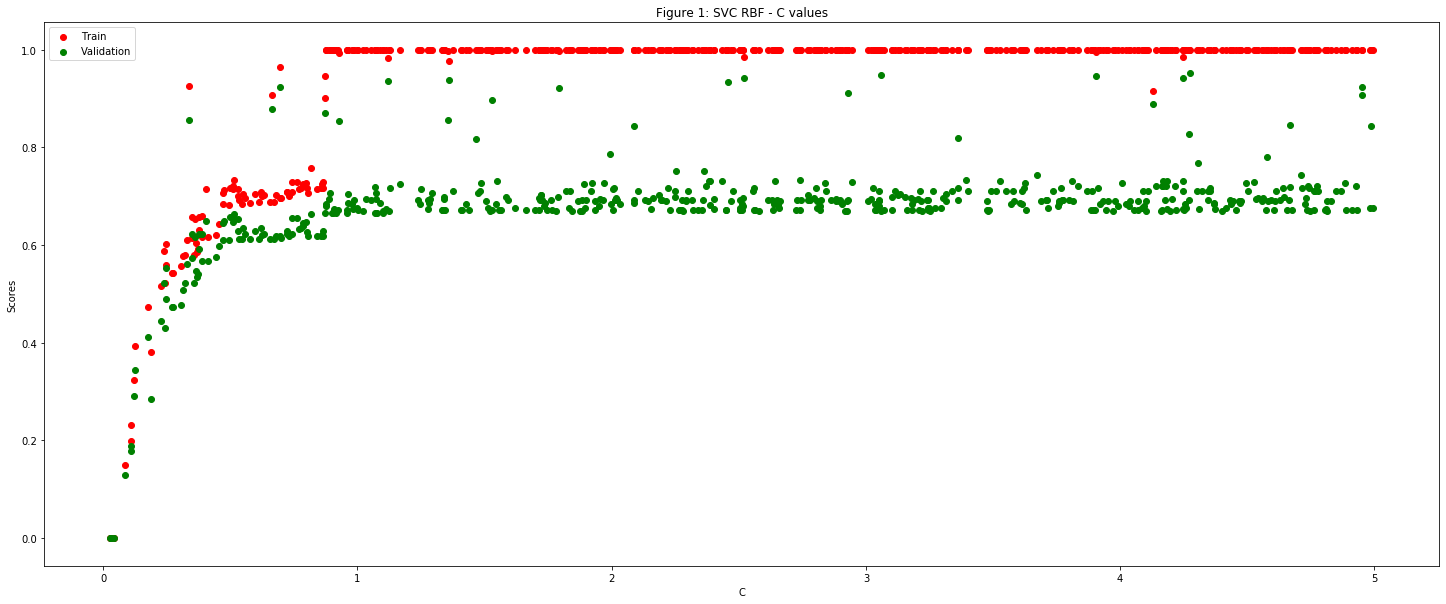

In [52]:
# Plot MCC Score vs C
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])       # Note: we consider test scores in the df as validation scores, to avoid conflict as we have test data untouched for this process
plt.title('Figure 1: SVC RBF - C values')
plt.show()

**Figure 1 - SVM RBF Kernel - Validation MCC vs C**

*Observation*
- The validation score increases linearly until C becomes 0.5 approximately.
- The score reaches the threshold and doesn't increase for higher values of C.
- After C=0.9 the model overfits.
- Between the 80-100% of the scores, there are few parameters for which the train and validation scores are near to each other.

*Sol: Look at the values little closer. For validation score between 80-100%, and avoid points for which the model overfits*

*Note: It will be interesting to look at the gamma value for the selected data points*

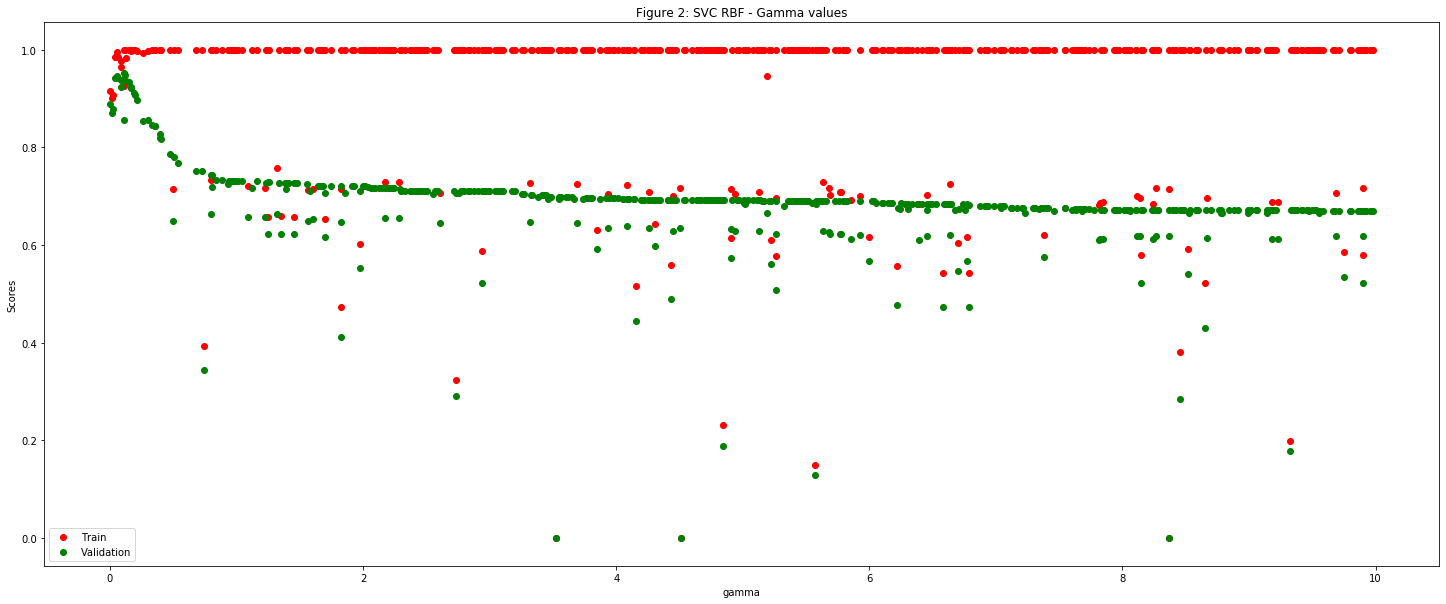

In [53]:
# Plot MCC Score vs Gamma
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['gamma'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['gamma'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('gamma')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 2: SVC RBF - Gamma values')
plt.show()

**Figure 2 - SVM RBF Kernel - Validation MCC vs Gamma**

*Observation*
- We can see an exponential decrease in the validation score for gamma value around 1.
- For higher value of gamma, the score decreases very slightly and the model starts to overfit.

*Sol: Look at the values little closer. For validation score between 80-100%, and avoid points for which the model overfits*

In [26]:
# Create another column 'diff' that shows the difference between train and the validation scores

SvcRbfAtrributes['diff'] = SvcRbfAtrributes['train_means'] - SvcRbfAtrributes['test_means']
SvcRbfAtrributes = SvcRbfAtrributes[(SvcRbfAtrributes['test_means'] >= 0.8) & (SvcRbfAtrributes['train_means'] != 1)]
SvcRbfAtrributes.sort_values(by = ['diff','test_stds'])

,rank,test_means,test_stds,train_means,train_stds,C,gamma,diff
405,15,0.888702,0.027529,0.915955,0.007014,4.131,0.0038,0.027252
86,17,0.870942,0.043781,0.899990,0.005048,0.872,0.0123,0.029048
413,16,0.877419,0.042888,0.907970,0.005840,0.663,0.0226,0.030551
187,6,0.937849,0.021299,0.976500,0.001915,1.360,0.0836,0.038651
123,10,0.922925,0.025860,0.965163,0.003530,0.694,0.0874,0.042238
2,5,0.942111,0.017279,0.985211,0.004391,2.520,0.0612,0.043100
386,4,0.942186,0.014528,0.985725,0.002600,4.248,0.0366,0.043539
17,7,0.935833,0.018317,0.983166,0.004149,1.122,0.1276,0.047333
62,3,0.946396,0.015708,0.994912,0.001609,3.903,0.0567,0.048516
357,19,0.855870,0.044944,0.925508,0.004612,0.338,0.1145,0.069638


_Note: By choosing the validation score more than 80%, we eliminated higher gamma values. We can see that the gamma value is not more than 0.3_

Selection criterion for hyperparameters:
- The validation (test_means) score must be high and should have less variations between validation and test scores.
- The standard deviations of scores must be minimum. 
- We can see the hyperparameter ranked 6 satisfies the conditions.

**Selected hyperparameter**

**C=1.360, gamma=0.0836**

In [123]:
svcRbfAllFeaturesParameter = {'name': 'SVM RBF Kernel', 'model': SVC(C=1.360, gamma=0.0836)}

### SVC Linear Kernel

In [ ]:
parameter = {'gamma' : np.arange(0.0001, 10, 0.0001), 'C' :  np.arange(0.0001, 10, 0.0001) } 

svc_linear = {'name': 'SVM Linear Kernel', 'model': SVC(kernel = 'linear'), 'params': parameter}

SvcLinAtrributes = pd.DataFrame(hypertune(svc_linear))
C = []
gamma = []
for y in SvcLinAtrributes['params']:
  C.append(y['C'])
  gamma.append(y['gamma'])

SvcLinAtrributes['C'] = C
SvcLinAtrributes['gamma'] = gamma
SvcLinAtrributes.drop(columns=['params'], inplace=True)

In [ ]:
# Do this if necessary

# Save the hyperparameter attributes in the dataframe
SvcLinAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcLinAtrributes_Xmms.csv",index=False)

In [94]:
# Load the dataframe
SvcLinAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcLinAtrributes_Xmms.csv")

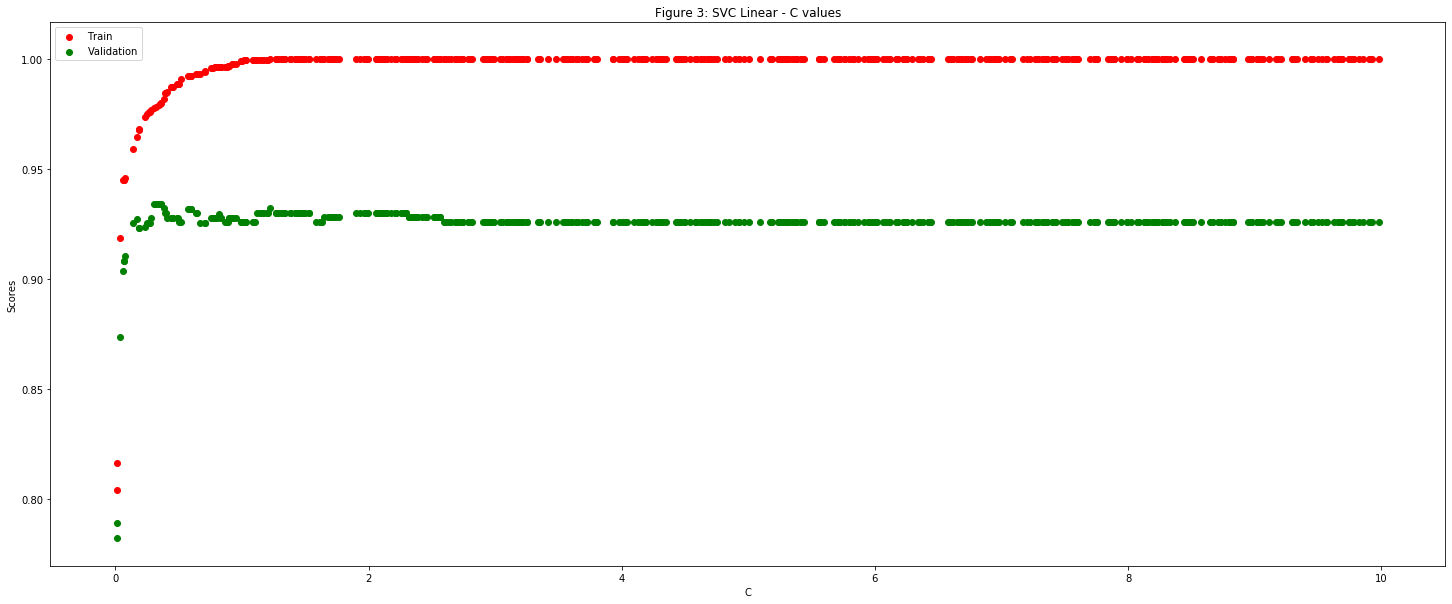

In [95]:
# Plot MCC Score vs C
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 3: SVC Linear - C values')
plt.show()

**Figure 3 - SVM Linear Kernel - Validation MCC vs C**

*Observation*
- We can see a steep increase in the validation score for lower C value, and the score becomes saturated for higher values.
- Also we can see, the model overfits for C value over 1.

*Sol: Look at the values little closer. For validation score between 80-100%, and avoid points for which the model overfits*

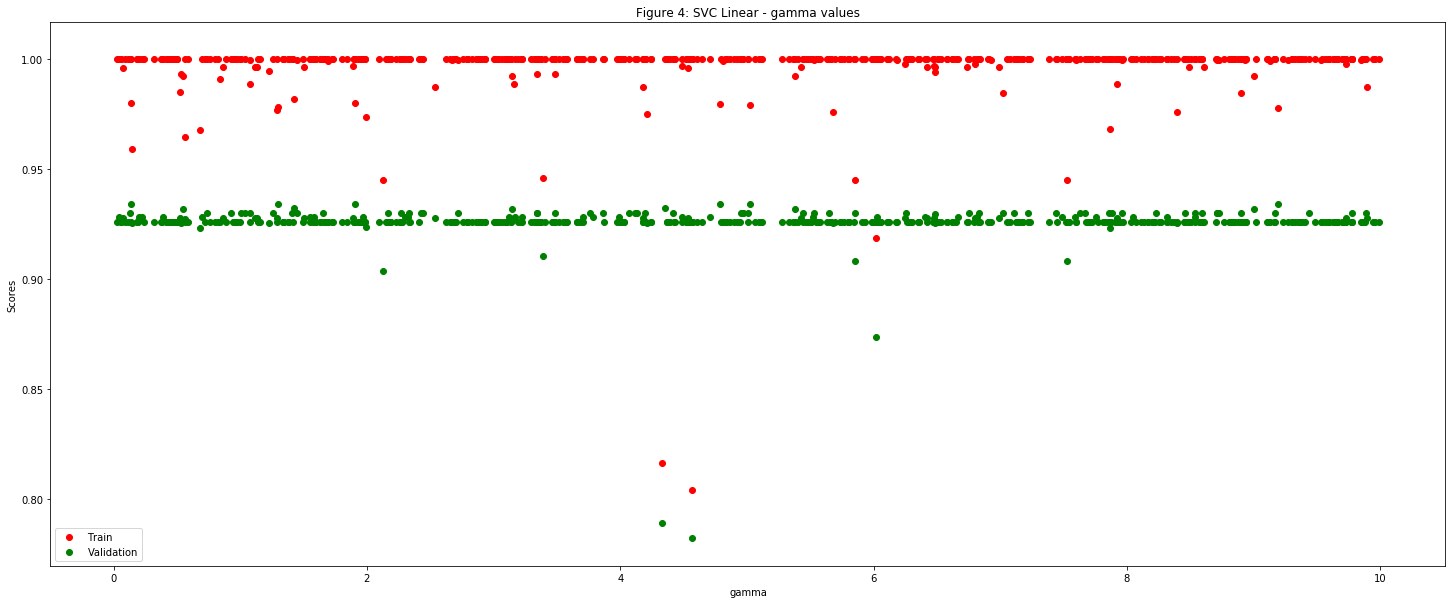

In [96]:
# Plot MCC Score vs Gamma
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcLinAtrributes['gamma'], SvcLinAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcLinAtrributes['gamma'], SvcLinAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('gamma')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 4: SVC Linear - gamma values')
plt.show()

**Figure 4 - SVM Linear Kernel - Validation MCC vs Gamma**

*Observation*
- We can see the gamma values doesn't have much impact on the scores.

*Sol: Choose the parameters primarily based on the C value*

In [33]:
# Create another column 'diff' that shows the difference between train and the validation scores

SvcLinAtrributes['diff'] = SvcLinAtrributes['train_means'] - SvcLinAtrributes['test_means']
SvcLinAtrributes = SvcLinAtrributes[(SvcLinAtrributes['test_means'] >= 0.8) & (SvcLinAtrributes['train_means'] != 1)]

pd.set_option('display.max_rows',None)
SvcLinAtrributes.sort_values(by = ['diff','test_stds'])

,rank,test_means,test_stds,train_means,train_stds,C,gamma,diff
343,490,0.925322,0.014305,0.958952,0.005443,0.1367,0.1452,0.033630
110,494,0.910300,0.031052,0.945940,0.006005,0.0777,3.3868,0.035639
14,495,0.907964,0.036922,0.944908,0.005938,0.0686,7.5239,0.036944
33,495,0.907964,0.036922,0.944908,0.005938,0.0672,5.8520,0.036944
213,122,0.927449,0.015231,0.964646,0.006186,0.1684,0.5675,0.037197
301,497,0.903601,0.039382,0.944913,0.004904,0.0588,2.1248,0.041311
150,1,0.934052,0.010751,0.977525,0.002515,0.3047,9.1950,0.043473
131,1,0.934052,0.010751,0.978038,0.002621,0.3237,1.2952,0.043986
270,492,0.923253,0.014610,0.967747,0.005532,0.1865,0.6808,0.044494
124,492,0.923253,0.014610,0.968262,0.005769,0.1873,7.8672,0.045009


_The parameters ranked 490 statisfies the condition for our selection criteria._

C = 0.1367, gamma =	0.1452

In [122]:
svcLinAllFeaturesParameter = {'name': 'SVM Linear Kernel', 'model': SVC(kernel='linear',C=1.367, gamma=0.1452)}

### Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
parameter = {'penalty' : ['l1', 'l2'], 'C' :  np.arange(0.0001, 10, 0.0001) }   

Logistic = {'name': 'Logistic', 'model': lr, 'params': parameter}

LogisticAtrributes = pd.DataFrame(hypertune(Logistic))

C = []
penalty = []
for y in LogisticAtrributes['params']:
  C.append(y['C'])
  penalty.append(y['penalty'])

LogisticAtrributes['C'] = C
LogisticAtrributes['penalty'] = penalty
LogisticAtrributes.drop(columns=['params'], inplace=True)

In [ ]:
LogisticAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/LogisticAtrributes.csv",index=False)

In [59]:
LogisticAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/LogisticAtrributes.csv")
LogisticAtrributes['diff'] = LogisticAtrributes['train_means'] - LogisticAtrributes['test_means']

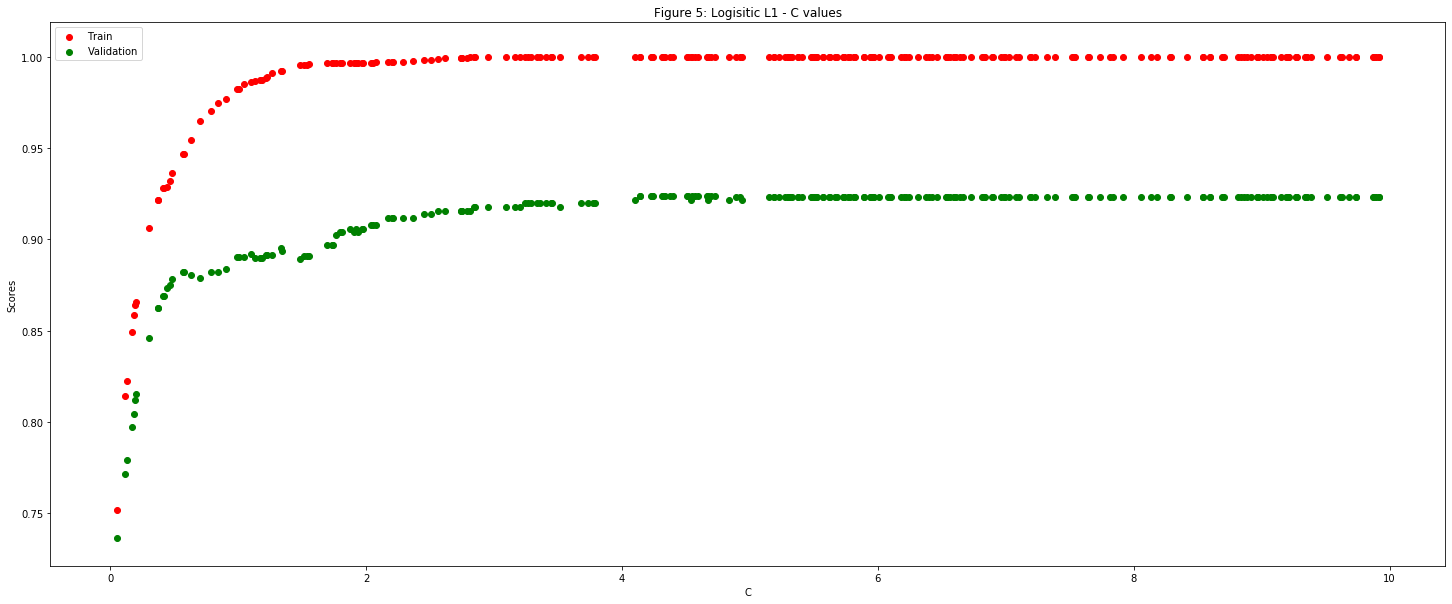

In [60]:
# For Penalty L1
LogisticHyperparameter_l1 = LogisticAtrributes[LogisticAtrributes['penalty'] == 'l1']

fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(LogisticHyperparameter_l1['C'], LogisticHyperparameter_l1['train_means'], marker ='o', color='r')
ax.scatter(LogisticHyperparameter_l1['C'], LogisticHyperparameter_l1['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 5: Logisitic L1 - C values')
plt.show()

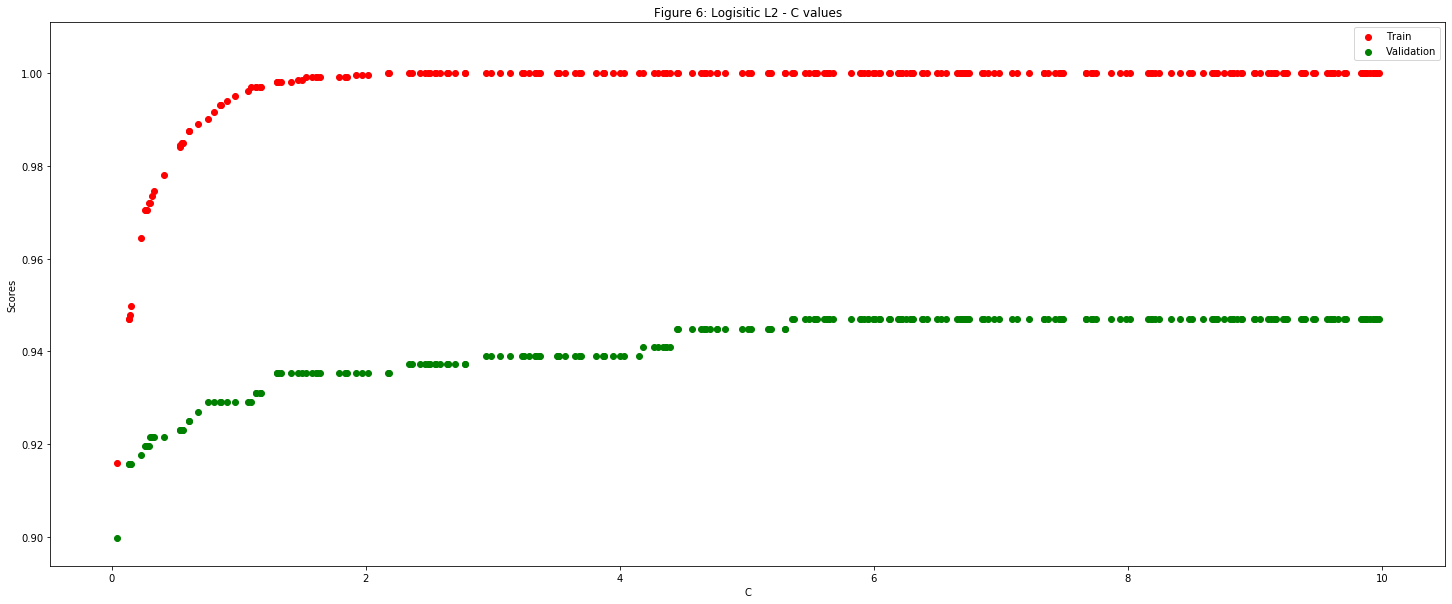

In [61]:
# For penalty L2
LogisticHyperparameter_l2 = LogisticAtrributes[LogisticAtrributes['penalty'] == 'l2']

fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(LogisticHyperparameter_l2['C'], LogisticHyperparameter_l2['train_means'], marker ='o', color='r')
ax.scatter(LogisticHyperparameter_l2['C'], LogisticHyperparameter_l2['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 6: Logisitic L2 - C values')
plt.show()

**Figure 5 & 6 - Logistic Regression - Validation MCC vs C for penalty L1 and L2 respectively**

*Observation*
- We can see the model overfits approximately for the C value over 1 for both penalty.
- L2 gives good score for smaller C value compared to L1, so we can choose penalty L2.

_Sol: We can select C value till 1 and look at the scores closely_

In [39]:
LogisticHyperparameter_l2['diff'] = LogisticHyperparameter_l2['train_means'] - LogisticHyperparameter_l2['test_means']
LogisticHyperparameter_l2 = LogisticHyperparameter_l2[LogisticHyperparameter_l2['C'] <= 1]

LogisticHyperparameter_l2.sort_values(by = ['diff', 'test_stds'])

,rank,test_means,test_stds,train_means,train_stds,C,penalty,diff
18,459,0.899785,0.013086,0.916072,0.006614,0.0385,l2,0.016288
34,429,0.915875,0.012080,0.946898,0.003217,0.1374,l2,0.031023
170,429,0.915875,0.012080,0.946898,0.003217,0.1347,l2,0.031023
324,429,0.915875,0.012080,0.947848,0.002857,0.1435,l2,0.031973
455,429,0.915875,0.012080,0.949867,0.005158,0.1526,l2,0.033992
301,421,0.917723,0.012104,0.964491,0.002027,0.2250,l2,0.046767
479,397,0.921511,0.012147,0.972013,0.001037,0.2975,l2,0.050503
23,417,0.919594,0.011519,0.970522,0.001861,0.2656,l2,0.050928
311,417,0.919594,0.011519,0.970522,0.001861,0.2770,l2,0.050928
490,417,0.919594,0.011519,0.970522,0.001861,0.2619,l2,0.050928


_The parameters ranked 459 satisfies our selection criteria_

C = 0.1347, penalty = l2

In [41]:
LogisticAllFeaturesParameter = {'name': 'Logistic', 'model': LogisticRegression(class_weight = 'balanced', solver = 'liblinear', C = 0.1347, penalty = 'l2')}

### Random Forest

In [69]:
rf = RandomForestClassifier(class_weight='balanced')

n_estimators = list(range(10,500,10))
max_features = ['auto','sqrt']
max_depth = list(range(2,20,1))
max_samples = np.arange(0.1,1.1,0.1)
bootstrap = [True]
class_weight = ['balanced', 'None']

parameter = {'n_estimators'   : n_estimators, 
               'max_features' : max_features,
               'max_depth'    : max_depth,
               'max_samples'  : max_samples,
               'bootstrap'    : bootstrap,
               'class_weight' : class_weight}

random_forest = {'name': 'Random Forest', 'model': rf, 'params': parameter}

RandomAtrributes = pd.DataFrame(hypertune(random_forest))

# Splitting the parameters in the dataframe
n_estimators = []
max_samples = []
max_features = []
max_depth = []
bootstrap = []
for y in RandomAtrributes['params']:
  n_estimators.append(y['n_estimators'])
  max_samples.append(y['max_samples'])
  max_features.append(y['max_features'])
  max_depth.append(y['max_depth'])

RandomAtrributes['n_estimators'] = n_estimators
RandomAtrributes['max_samples'] = max_samples
RandomAtrributes['max_features'] = max_features
RandomAtrributes['max_depth'] = max_depth
RandomAtrributes.drop(columns=['params'], inplace=True)

RandomAtrributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/RandomAtrributes.csv', index=False)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1275 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1275 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 367, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 762, in _validate_y_class_weight
    % self.class_weight
ValueError: Val

In [97]:
RfAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/RandomAtrributes.csv')

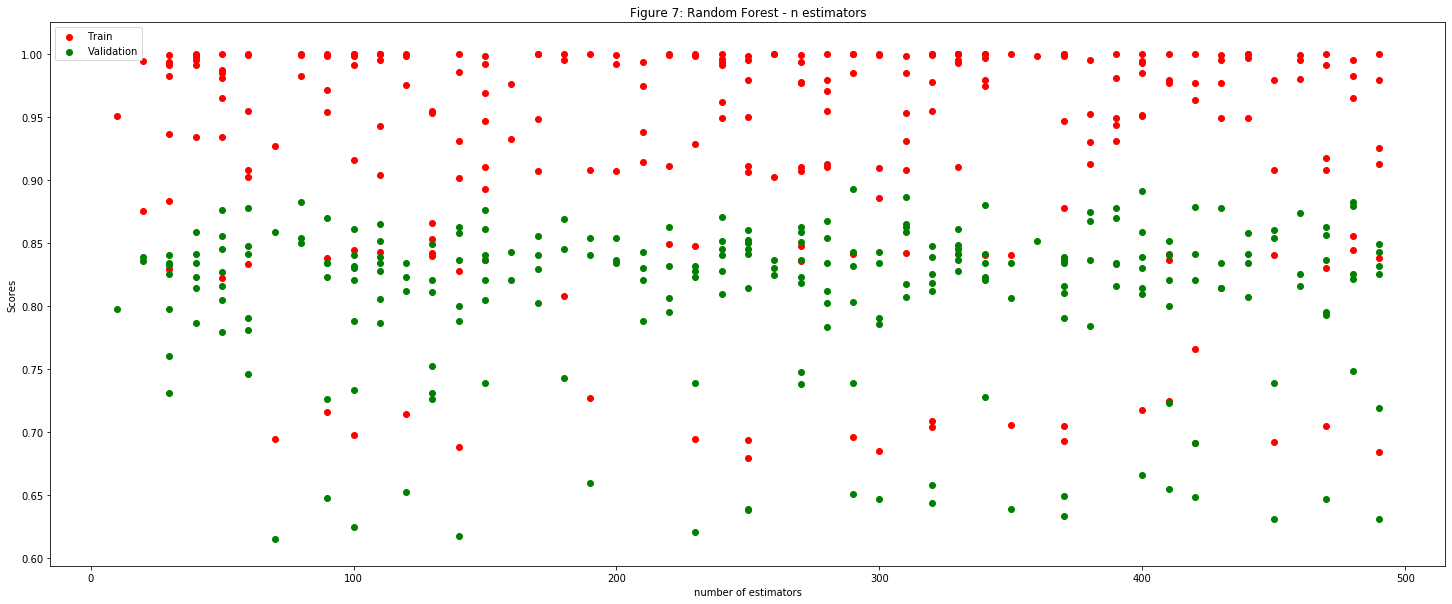

In [98]:
# Plot number of estimator vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['n_estimators'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['n_estimators'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('number of estimators')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 7: Random Forest - n estimators')
plt.show()

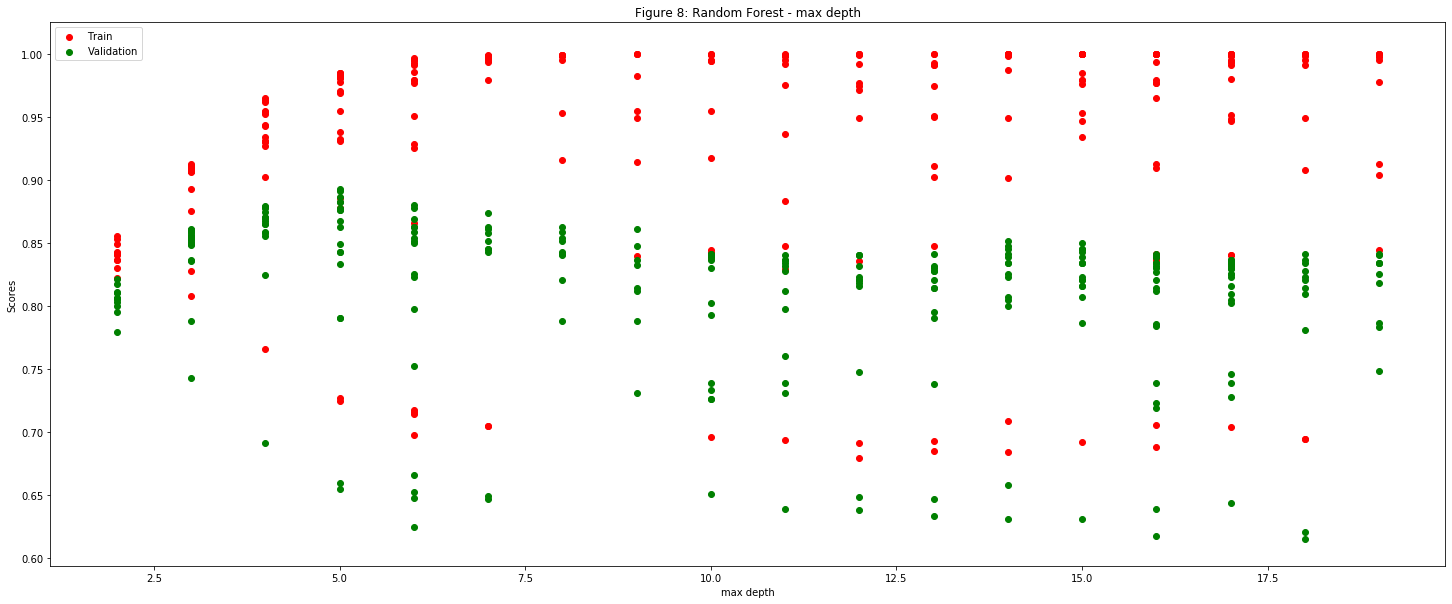

In [99]:
# Plot depth vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_depth'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_depth'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max depth')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 8: Random Forest - max depth')
plt.show()

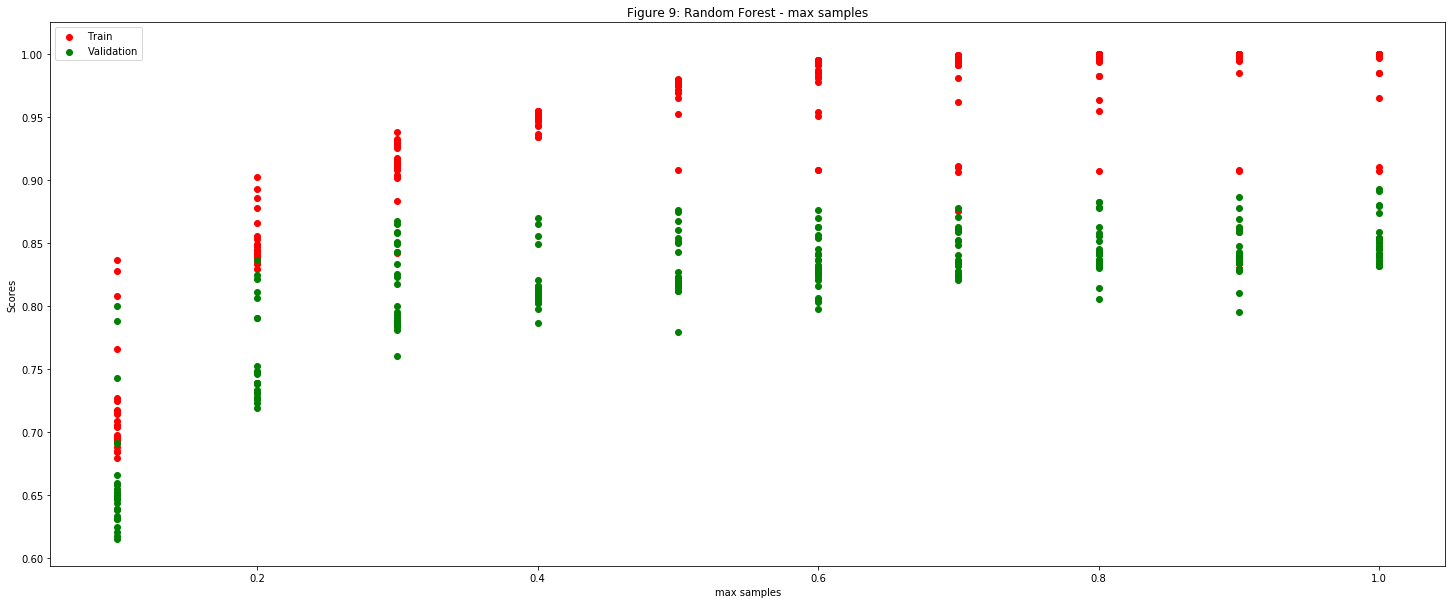

In [100]:
# Plot Samples vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_samples'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_samples'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max samples')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 9: Random Forest - max samples')
plt.show()

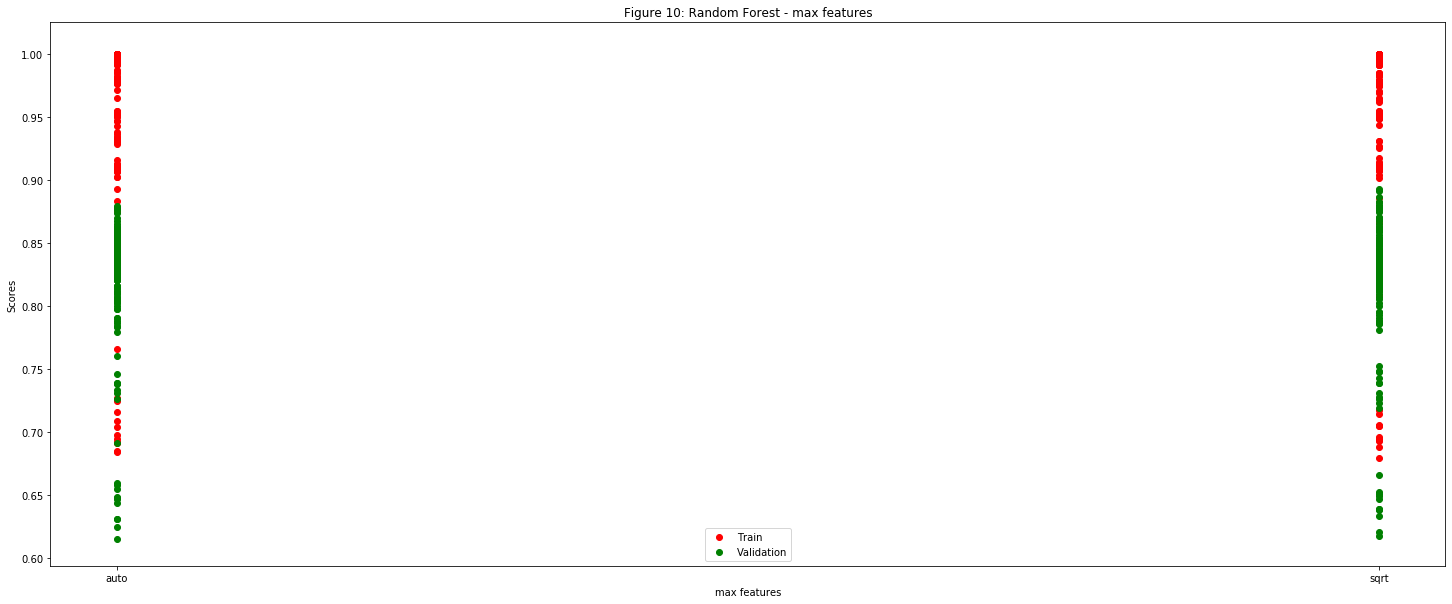

In [101]:
# Plot features vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_features'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_features'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max features')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 10: Random Forest - max features')
plt.show()

**Figure 7-10 - Random Forest - MCC scores vs features**

**_Observations_**
- we can see from the figures that we cannot select a range of parameters as we did for other features as we dont see any clear variation in the score vs parameter values except depth and max sample.
- The score is high when the depth is around 5.
- The score increases for increasing values of max depth

_Sol: Choose the MCC more than 85% and select the parameters based on our criteria_

In [73]:
RfAttributes = RfAttributes[RfAttributes['test_means'] >= 0.85]
RfAttributes['diff'] = RfAttributes['train_means'] - RfAttributes['test_means']

RfAttributes.sort_values(by=['diff', 'test_stds'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rank,test_means,test_stds,train_means,train_stds,n_estimators,max_samples,max_features,max_depth,diff
302,33,0.859960,0.030553,0.907711,0.008456,450,0.5,sqrt,3,0.047751
383,35,0.858552,0.025135,0.907045,0.008863,270,0.9,auto,3,0.048493
192,36,0.858506,0.030197,0.907708,0.012564,310,0.9,auto,3,0.049202
377,29,0.860795,0.028479,0.910339,0.004764,150,0.7,auto,3,0.049545
72,32,0.860155,0.024125,0.911240,0.008130,250,0.7,sqrt,3,0.051085
465,43,0.855401,0.034821,0.907342,0.010066,170,0.8,auto,3,0.051941
64,41,0.855936,0.029638,0.908089,0.009226,470,0.6,sqrt,3,0.052153
317,44,0.854183,0.026123,0.907027,0.008441,200,1.0,sqrt,3,0.052844
202,49,0.852349,0.019138,0.905963,0.007082,250,0.7,auto,3,0.053614
142,45,0.854170,0.033410,0.908169,0.015410,190,0.6,auto,3,0.053999


_Choosing the parameter with rank 29_

n_estimators = 150, max_samples = 0.7,	max_features = 'auto',	max_depth = 3

_Note: Overfitting is high in Random Forest, reducing the number of features might improve the performance_

In [74]:
RandomAllFeaturesParameter = {'name': 'Random', 'model': RandomForestClassifier(class_weight = 'balanced', bootstrap = True,n_estimators = 150, max_samples = 0.7, max_features = 'auto', max_depth = 3)}

### KNN

In [ ]:
knn = KNeighborsClassifier()
parameter = {'n_neighbors' : range(1,21), 'weights' : ['uniform', 'distance']}

knn = {'name': 'KNN', 'model': knn, 'params': parameter}

knnAttributes = pd.DataFrame(hypertune(knn))
n_neighbors = []
weights = []

for y in knnAttributes['params']:
  n_neighbors.append(y['n_neighbors'])
  weights.append(y['weights'])

knnAttributes['n_neighbors'] = n_neighbors
knnAttributes['weights'] = weights
knnAttributes.drop(columns=['params'], inplace=True)

knnAttributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnAttributes.csv', index=False)

In [81]:
knnAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnAttributes.csv')


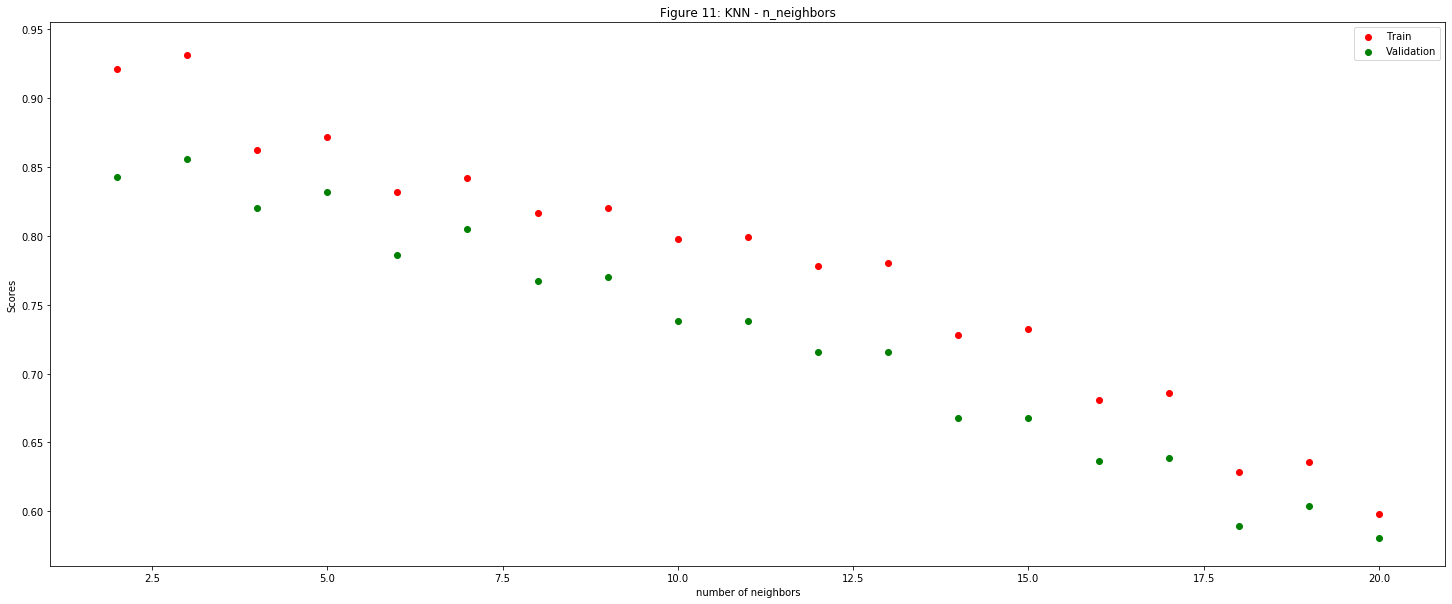

In [102]:
# Plot validation score vs n neighbors
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['train_means'], marker ='o', color='r')
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 11: KNN - n_neighbors')
plt.show()

**Figure 11: Validation scores vs number of neighbors**

**_Observations_**
- We can see that the scores are decreasing when the number of neighbors are increasing.
- Also we can see the values are overfitting.

_Sol: Choose train scores that are not 100% and select the parameters_

In [84]:
knnAttributes = knnAttributes[knnAttributes['train_means'] != 1]
knnAttributes['diff'] = knnAttributes['train_means'] - knnAttributes['test_means']
knnAttributes.sort_values(by=['diff', 'test_stds'])

,rank,test_means,test_stds,train_means,train_stds,n_neighbors,weights,diff
38,40,0.580493,0.054032,0.598295,0.009263,20,uniform,0.017802
36,38,0.604069,0.042078,0.635902,0.018781,19,uniform,0.031833
12,24,0.804736,0.027189,0.842266,0.007394,7,uniform,0.037530
34,39,0.589064,0.054817,0.628388,0.022541,18,uniform,0.039324
8,14,0.831814,0.026350,0.871953,0.007374,5,uniform,0.040139
6,15,0.820496,0.028518,0.862668,0.007820,4,uniform,0.042172
30,37,0.636533,0.049401,0.680905,0.025965,16,uniform,0.044372
10,27,0.786156,0.034628,0.831638,0.012121,6,uniform,0.045482
32,36,0.639039,0.051782,0.685995,0.026153,17,uniform,0.046957
14,29,0.767628,0.027523,0.816377,0.019381,8,uniform,0.048749


_Choosing the parameter with rank 24_

n_neighbors = 7, weights = 'uniform'

In [85]:
KnnAllFeaturesParameter = {'name': 'KNN', 'model': KNeighborsClassifier(n_neighbors=7, weights='uniform')}

### XG Boost

In [ ]:
parameter = {'gamma': np.arange(0.0001, 1, 0.0001),
              'learning_rate': np.arange(0.01,10,0.01),
              'max_depth': list(range(1,51)),
              'n_estimators': list(range(50,500,10)),
              'reg_alpha': np.arange(0,10,0.01),
              'reg_lambda': np.arange(0,10,0.01)}

xgbooster = {'name': 'XGBooster', 'model': XGBClassifier(), 'params': parameter}

xgbAttributes =  pd.DataFrame(hypertune(xgbooster))

learning_rate = []
max_depth = []
n_estimators = []
reg_alpha = []
reg_lambda = []
gamma = []

for y in xgbAttributes['params']:
  n_estimators.append(y['n_estimators'])
  learning_rate.append(y['learning_rate'])
  reg_alpha.append(y['reg_alpha'])
  max_depth.append(y['max_depth'])
  reg_lambda.append(y['reg_lambda'])
  gamma.append(y['gamma'])

xgbAttributes['n_estimators'] = n_estimators
xgbAttributes['learning_rate'] = learning_rate
xgbAttributes['reg_alpha'] = reg_alpha
xgbAttributes['max_depth'] = max_depth
xgbAttributes['reg_lambda'] = reg_lambda
xgbAttributes['gamma'] = gamma
xgbAttributes.drop(columns=['params'], inplace=True)

xgbAttributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbAttributes.csv', index=False)

In [87]:
xgbAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbAttributes.csv')

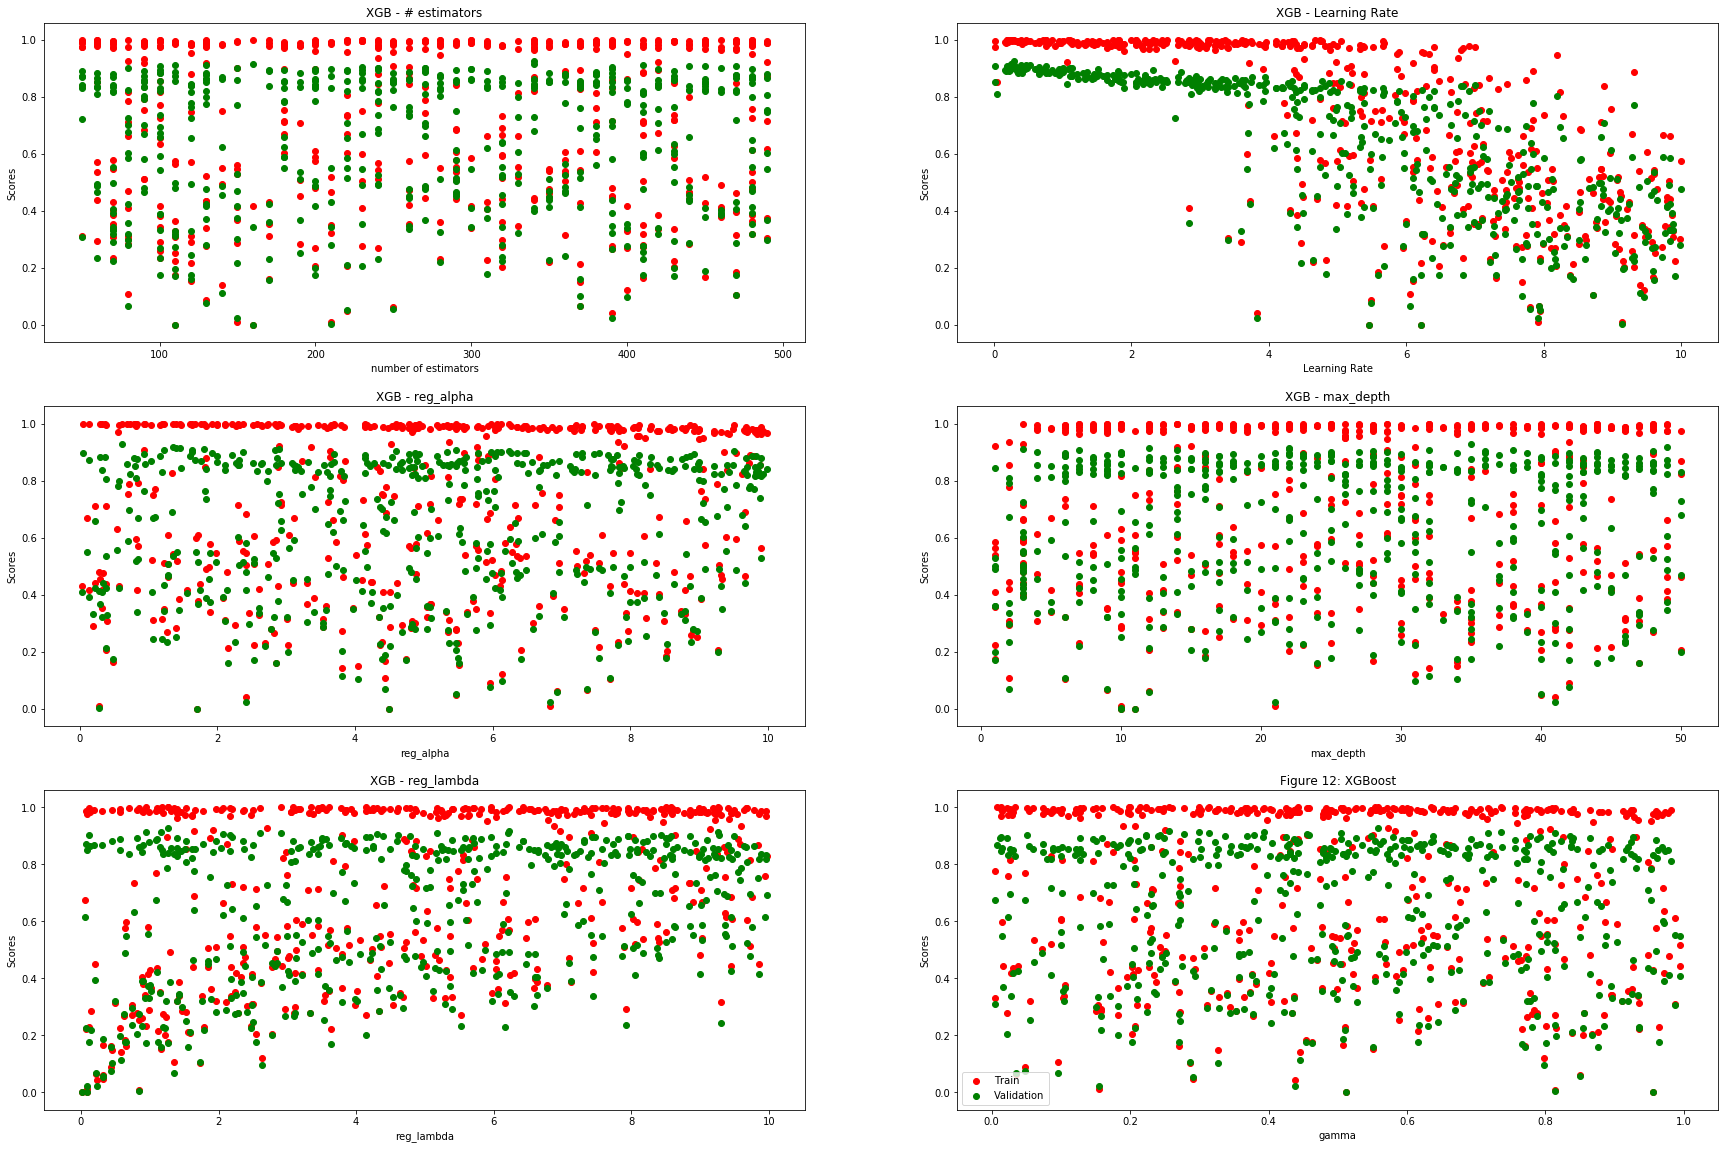

In [103]:
# Plot validation score vs n_estimators
fig,ax = plt.subplots(3,2,figsize=[30,20])
ax[0,0].scatter(xgbAttributes['n_estimators'], xgbAttributes['train_means'], marker ='o', color='r')
ax[0,0].scatter(xgbAttributes['n_estimators'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[0,0].set_xlabel('number of estimators')
ax[0,0].set_ylabel('Scores')
ax[0,0].set_title('XGB - # estimators')

# Plot validation score vs learning rate
ax[0,1].scatter(xgbAttributes['learning_rate'], xgbAttributes['train_means'], marker ='o', color='r')
ax[0,1].scatter(xgbAttributes['learning_rate'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[0,1].set_xlabel('Learning Rate')
ax[0,1].set_ylabel('Scores')
ax[0,1].set_title('XGB - Learning Rate')

# Plot validation score vs reg_alpha
ax[1,0].scatter(xgbAttributes['reg_alpha'], xgbAttributes['train_means'], marker ='o', color='r')
ax[1,0].scatter(xgbAttributes['reg_alpha'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[1,0].set_xlabel('reg_alpha')
ax[1,0].set_ylabel('Scores')
ax[1,0].set_title('XGB - reg_alpha')

# Plot validation score vs max_depth
ax[1,1].scatter(xgbAttributes['max_depth'], xgbAttributes['train_means'], marker ='o', color='r')
ax[1,1].scatter(xgbAttributes['max_depth'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[1,1].set_xlabel('max_depth')
ax[1,1].set_ylabel('Scores')
ax[1,1].set_title('XGB - max_depth')

# Plot validation score vs reg_lambda
ax[2,0].scatter(xgbAttributes['reg_lambda'], xgbAttributes['train_means'], marker ='o', color='r')
ax[2,0].scatter(xgbAttributes['reg_lambda'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[2,0].set_xlabel('reg_lambda')
ax[2,0].set_ylabel('Scores')
ax[2,0].set_title('XGB - reg_lambda')

# Plot validation score vs gamma
ax[2,1].scatter(xgbAttributes['gamma'], xgbAttributes['train_means'], marker ='o', color='r')
ax[2,1].scatter(xgbAttributes['gamma'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[2,1].set_xlabel('gamma')
ax[2,1].set_ylabel('Scores')
ax[2,1].set_title('XGB - gamma')


plt.legend(['Train', 'Validation'])
plt.title('Figure 12: XGBoost')
plt.show()

**Figure 12: Validation scores vs parameters**

**_Observations_**
- We can see the values are spreaded all over for all the features except learning rate.
- Scores are decreasing when the learning rate is increased.

_Sol: Since we don't have clear variations, select the validation scores more than 85% and choose the best parameters_

In [105]:
xgbAttributes = xgbAttributes[(xgbAttributes['train_means'] != 1) & (xgbAttributes['test_means'] >= 0.80)]
xgbAttributes['diff'] = xgbAttributes['train_means'] - xgbAttributes['test_means']
xgbAttributes.sort_values(by=['diff', 'test_stds'])

,rank,test_means,test_stds,train_means,train_stds,n_estimators,learning_rate,reg_alpha,max_depth,reg_lambda,gamma,diff
306,3,0.914798,0.022386,0.999490,0.001020,160,0.26,1.40,22,0.94,0.7355,0.084692
205,6,0.910777,0.021398,0.996950,0.001902,110,0.53,1.81,3,6.21,0.5054,0.086174
221,5,0.912625,0.025675,0.998984,0.001245,410,0.46,2.89,22,1.16,0.3929,0.086359
440,7,0.908437,0.022744,0.996949,0.001016,450,0.31,2.84,38,5.17,0.7166,0.088512
13,9,0.908305,0.014260,0.997457,0.001608,440,0.01,1.63,14,2.61,0.8141,0.089152
281,10,0.908198,0.027146,0.997966,0.001017,470,0.19,5.46,7,4.30,0.2781,0.089768
146,21,0.898186,0.020099,0.988793,0.004139,300,0.59,6.36,22,7.95,0.8356,0.090607
35,12,0.904182,0.021518,0.994912,0.003216,230,0.26,9.51,28,8.43,0.2431,0.090730
264,11,0.904705,0.017673,0.996949,0.001016,390,0.66,6.23,48,2.06,0.4561,0.092244
438,46,0.885558,0.014551,0.978548,0.002617,190,0.76,9.82,6,9.10,0.6028,0.092990


_Note: No parameter values are good enough, we can clearly see that the values are overfitting_

_Sol: Reduce number of features_

# Recursive Feature Elimination

## Function

In [117]:
def kfold_modelling(optimized_model, X=X_mms, y=y_):
    
    model = optimized_model['model']
    skf = StratifiedKFold(n_splits=10)
    
    # Calculate Accuracy, F1, and MCC Values of the Validation set
    accuracy_valid = []
    f1_positive_valid = []
    f1_negative_valid = []
    mcc_valid = []

    # Calculate Accuracy, F1, and MCC Values of the training set
    accuracy_train = []
    f1_positive_train = []
    f1_negative_train = []
    mcc_train = []
    
    for train_index, test_index in skf.split(X,y):
        
        # Generate train and test sets
        X_train_kfold, X_valid_kfold = X.iloc[train_index], X.iloc[test_index]
        y_train_kfold, y_valid_kfold = y.iloc[train_index], y.iloc[test_index]

        # Model Fitting
        model.fit(X_train_kfold,y_train_kfold)
        
        # Now we make the predictions on both the training and test sets of the model.
        y_pred_train_kfold = model.predict(X_train_kfold)
        y_pred_valid_kfold = model.predict(X_valid_kfold)
        
        # Calculate Accuracy, F1, and MCC Values of the Validation set
        accuracy_valid.append(accuracy_score(y_valid_kfold, y_pred_valid_kfold)*100)
        f1_positive_valid.append(f1_score(y_valid_kfold, y_pred_valid_kfold)*100)
        f1_negative_valid.append(f1_score(1-y_valid_kfold, 1-y_pred_valid_kfold)*100)
        mcc_valid.append(matthews_corrcoef(y_valid_kfold, y_pred_valid_kfold)*100)

        # Calculate Accuracy, F1, and MCC Values of the training set
        accuracy_train.append(accuracy_score(y_train_kfold, y_pred_train_kfold)*100)
        f1_positive_train.append(f1_score(y_train_kfold, y_pred_train_kfold)*100)
        f1_negative_train.append(f1_score(1-y_train_kfold, 1-y_pred_train_kfold)*100)
        mcc_train.append(matthews_corrcoef(y_train_kfold, y_pred_train_kfold)*100)
    
    # Mean values of the Validation set
    accuracy_mean_valid = np.mean(accuracy_valid)
    f1_positive_mean_valid = np.mean(f1_positive_valid)
    f1_negative_mean_valid = np.mean(f1_negative_valid)
    mcc_mean_valid = np.mean(mcc_valid)

    # Mean values of the train set
    accuracy_mean_train = np.mean(accuracy_train)
    f1_positive_mean_train = np.mean(f1_positive_train)
    f1_negative_mean_train = np.mean(f1_negative_train)
    mcc_mean_train = np.mean(mcc_train)
    
    new_dict_kfold = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_mean_train,'Train F1 Negative' : f1_negative_mean_valid, 'Train F1 Positive':f1_positive_mean_train, 
                      'Train MCC Score' : mcc_mean_train, 'Validation Accuracy':accuracy_mean_valid,'Validation F1 Negative' : f1_negative_mean_valid, 
                      'Validation F1 Positive':f1_positive_mean_valid, 'Validation MCC Score' : mcc_mean_valid}
    new_df_kfold = pd.DataFrame(new_dict_kfold, index=[0])

    return new_df_kfold

In [125]:
def rfeModelling (optimized_model, X = X_mms, y = y_):
    
    model = optimized_model['model']
    
    features = {}
    X_rfe = pd.DataFrame()
    for feature in reversed(range(1,572,1)):
        
        print(feature, end=' ')
        
        rfe_model = RFE(model, n_features_to_select=feature, step=1)
        rfe_model.fit(X,y)
        
        X_selected = rfe_model.transform(X)
        X_selected_labels = rfe_model.get_support()
        X_selected_features = list(filter(None, X.columns * X_selected_labels))
        
        features[feature] = X_selected_features
        
        X = pd.DataFrame(data=X_selected,columns=X_selected_features)
        
        X_kfold = kfold_modelling(optimized_model, X, y)
        X_kfold['Num Features'] = feature
        
        X_rfe = pd.concat([X_rfe, X_kfold])

    return X_rfe,features

In [119]:
def plot_features(features_df, optimized_model):
    # Multiple lines in same plot
    plt.figure(figsize=(25,10))

    # Plot
    plt.plot('Num Features', 'Train MCC Score', data=features_df)
    #plt.plot('Features Selected', 'Test MCC Score', data=features_df)
    plt.plot('Num Features', 'Validation MCC Score', data=features_df)

    # Decorate
    plt.xlabel('Number of Features Selected')
    plt.ylabel('MCC Score')
    plt.legend()
    plt.title('%s' % optimized_model['name'])
    # plt.xlim(1,150)
    #plt.ylim(0, 90)
    plt.show()

## RFE -> SVC Linear

In [121]:
svcLinAllFeaturesParameter

{'name': 'SVM Linear Kernel',
 'function': SVC(C=1.367, gamma=0.1452, kernel='linear')}

In [126]:
svcLinRfeResults, svcLinRfeFeatures = rfeModelling(optimized_model=svcLinAllFeaturesParameter)

571 570 569 568 567 566 565 564 563 562 561 560 559 558 557 556 555 554 553 552 551 550 549 548 547 546 545 544 543 542 541 540 539 538 537 536 535 534 533 532 531 530 529 528 527 526 525 524 523 522 521 520 519 518 517 516 515 514 513 512 511 510 509 508 507 506 505 504 503 502 501 500 499 498 497 496 495 494 493 492 491 490 489 488 487 486 485 484 483 482 481 480 479 478 477 476 475 474 473 472 471 470 469 468 467 466 465 464 463 462 461 460 459 458 457 456 455 454 453 452 451 450 449 448 447 446 445 444 443 442 441 440 439 438 437 436 435 434 433 432 431 430 429 428 427 426 425 424 423 422 421 420 419 418 417 416 415 414 413 412 411 410 409 408 407 406 405 404 403 402 401 400 399 398 397 396 395 394 393 392 391 390 389 388 387 386 385 384 383 382 381 380 379 378 377 376 375 374 373 372 371 370 369 368 367 366 365 364 363 362 361 360 359 358 357 356 355 354 353 352 351 350 349 348 347 346 345 344 343 342 341 340 339 338 337 336 335 334 333 332 331 330 329 328 327 326 325 324 323 322 

In [127]:
svcLinRfeResults.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/svcLinRfeResults_3.csv",index=False)

In [ ]:
svcLinRfeResults = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/svcLinRfeResults_3.csv")

In [ ]:
pd.set_option('display.max_rows',None)
svcLinRfeResults

In [ ]:
svcLinRfeResults['diff'] = svcLinRfeResults['Train MCC Score'] - svcLinRfeResults['Validation MCC Score']
svcLinRfeResults.sort_values('diff')

In [ ]:
plot_features(svcLinRfeResults,svcLinAllFeaturesParameter)

In [ ]:
plot_features(svcLinRfeResults,svcLinAllFeaturesParameter)

In [ ]:
plot_features(svcLinRfeResults,svcLinAllFeaturesParameter)

Selected Number of features 165, significantly high validation score and less difference between train and validation scores

In [ ]:
selected_features = svcLinRfeFeatures[165]
selected_features

selected_features = ['IsoelectricPoint',
 'A',
 'C',
 'E',
 'G',
 'I',
 'L',
 'K',
 'M',
 'P',
 'W',
 '_PolarizabilityC2',
 '_SolventAccessibilityC1',
 '_SecondaryStrC1',
 '_SecondaryStrC3',
 '_ChargeC2',
 '_ChargeC3',
 '_PolarityC1',
 '_PolarityC2',
 '_NormalizedVDWVC1',
 '_HydrophobicityC1',
 '_HydrophobicityC3',
 '_SolventAccessibilityT13',
 '_SecondaryStrT12',
 '_SecondaryStrT23',
 '_ChargeT13',
 '_ChargeT23',
 '_PolarityT23',
 '_HydrophobicityT12',
 '_HydrophobicityT23',
 '_PolarizabilityD1050',
 '_PolarizabilityD2050',
 '_PolarizabilityD2075',
 '_PolarizabilityD3050',
 '_PolarizabilityD3100',
 '_SolventAccessibilityD1050',
 '_SolventAccessibilityD2001',
 '_SolventAccessibilityD3001',
 '_SolventAccessibilityD3050',
 '_SecondaryStrD1050',
 '_SecondaryStrD1100',
 '_SecondaryStrD2050',
 '_SecondaryStrD2075',
 '_SecondaryStrD2100',
 '_SecondaryStrD3100',
 '_ChargeD1025',
 '_ChargeD1050',
 '_ChargeD2001',
 '_ChargeD2025',
 '_ChargeD2075',
 '_ChargeD3050',
 '_ChargeD3075',
 '_ChargeD3100',
 '_PolarityD1001',
 '_PolarityD1050',
 '_PolarityD1100',
 '_NormalizedVDWVD1025',
 '_NormalizedVDWVD1100',
 '_NormalizedVDWVD2001',
 '_NormalizedVDWVD3050',
 '_NormalizedVDWVD3100',
 '_HydrophobicityD1001',
 '_HydrophobicityD2100',
 '_HydrophobicityD3001',
 '_HydrophobicityD3050',
 'AE',
 'AF',
 'AP',
 'AS',
 'AT',
 'RN',
 'RE',
 'RL',
 'RF',
 'RP',
 'NQ',
 'NG',
 'NF',
 'NS',
 'DC',
 'DE',
 'DF',
 'DP',
 'CC',
 'CE',
 'CI',
 'CL',
 'CY',
 'EN',
 'ED',
 'EE',
 'EQ',
 'EG',
 'EI',
 'EL',
 'ES',
 'ET',
 'EY',
 'QN',
 'QD',
 'QC',
 'QL',
 'QT',
 'GN',
 'GD',
 'GE',
 'GQ',
 'GI',
 'GL',
 'GK',
 'GS',
 'GV',
 'HR',
 'HC',
 'HE',
 'HM',
 'IA',
 'IN',
 'II',
 'IK',
 'IP',
 'LA',
 'LD',
 'LE',
 'LK',
 'KA',
 'KR',
 'KN',
 'KE',
 'KK',
 'KM',
 'KF',
 'KS',
 'KY',
 'MQ',
 'MG',
 'MH',
 'MP',
 'MT',
 'FE',
 'FT',
 'PG',
 'PH',
 'PL',
 'PK',
 'PY',
 'SE',
 'SQ',
 'SG',
 'SS',
 'TA',
 'TD',
 'TQ',
 'TG',
 'TI',
 'TF',
 'TY',
 'WN',
 'WW',
 'YN',
 'YD',
 'YE',
 'YH',
 'YT',
 'VR']

## RFE - Logistic

In [ ]:
LogisticAllFeaturesParameter

In [ ]:
logisticRfeResults, logisticRfeFeatures = rfeModelling(optimized_model=LogisticAllFeaturesParameter)

In [ ]:
logisticRfeResults.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over Useless/logisticRfeResults.csv",index=False)

In [ ]:
pd.set_option('display.max_rows',None)
logisticRfeResults['diff'] = logisticRfeResults['Train MCC Score'] - logisticRfeResults['Validation MCC Score']
logisticRfeResults.sort_values('diff')

In [ ]:
plot_features(logisticRfeResults,LogisticAllFeaturesParameter)

# Hyperparameter w/Selected Features

In [ ]:
selected_features = ['IsoelectricPoint', 'A', 'C', 'E', 'G', 'I', 'L', 'K', 'M', 'P', 'W', '_PolarizabilityC2', '_SolventAccessibilityC1', '_SecondaryStrC1', '_SecondaryStrC3', '_ChargeC2', '_ChargeC3', '_PolarityC1', '_PolarityC2', '_NormalizedVDWVC1', '_HydrophobicityC1', '_HydrophobicityC3', '_SolventAccessibilityT13', '_SecondaryStrT12', '_SecondaryStrT23', '_ChargeT13', '_ChargeT23', '_PolarityT23', '_HydrophobicityT12', '_HydrophobicityT23', '_PolarizabilityD1050', '_PolarizabilityD2050', '_PolarizabilityD2075', '_PolarizabilityD3050', '_PolarizabilityD3100', '_SolventAccessibilityD1050', '_SolventAccessibilityD2001', '_SolventAccessibilityD3001', '_SolventAccessibilityD3050', '_SecondaryStrD1050', '_SecondaryStrD1100', '_SecondaryStrD2050', '_SecondaryStrD2075', '_SecondaryStrD2100', '_SecondaryStrD3100', '_ChargeD1025', '_ChargeD1050', '_ChargeD2001', '_ChargeD2025', '_ChargeD2075', '_ChargeD3050', '_ChargeD3075', '_ChargeD3100', '_PolarityD1001', '_PolarityD1050', '_PolarityD1100', '_NormalizedVDWVD1025', '_NormalizedVDWVD1100', '_NormalizedVDWVD2001', '_NormalizedVDWVD3050', '_NormalizedVDWVD3100', '_HydrophobicityD1001', '_HydrophobicityD2100', '_HydrophobicityD3001', '_HydrophobicityD3050', 'AE', 'AF', 'AP', 'AS', 'AT', 'RN', 'RE', 'RL', 'RF', 'RP', 'NQ', 'NG', 'NF', 'NS', 'DC', 'DE', 'DF', 'DP', 'CC', 'CE', 'CI', 'CL', 'CY', 'EN', 'ED', 'EE', 'EQ', 'EG', 'EI', 'EL', 'ES', 'ET', 'EY', 'QN', 'QD', 'QC', 'QL', 'QT', 'GN', 'GD', 'GE', 'GQ', 'GI', 'GL', 'GK', 'GS', 'GV', 'HR', 'HC', 'HE', 'HM', 'IA', 'IN', 'II', 'IK', 'IP', 'LA', 'LD', 'LE', 'LK', 'KA', 'KR', 'KN', 'KE', 'KK', 'KM', 'KF', 'KS', 'KY', 'MQ', 'MG', 'MH', 'MP', 'MT', 'FE', 'FT', 'PG', 'PH', 'PL', 'PK', 'PY', 'SE', 'SQ', 'SG', 'SS', 'TA', 'TD', 'TQ', 'TG', 'TI', 'TF', 'TY', 'WN', 'WW', 'YN', 'YD', 'YE', 'YH', 'YT', 'VR']

In [ ]:
X_train_mms = X_train_mms[selected_features]
X_test_mms = X_test_mms[selected_features]

## SVC RBF Kernel

In [ ]:
parameter = {'gamma' : np.arange(0.0001, 10, 0.0001), 'C' :  np.arange(0.0001, 10, 0.0001) }

svc_rbf = {'name': 'SVM w/RBF Kernel', 'model': SVC(), 'params': parameter}

SvcRbfAtrributes = pd.DataFrame(hypertune(svc_rbf))
C = []
gamma = []
for y in SvcRbfAtrributes['params']:
  C.append(y['C'])
  gamma.append(y['gamma'])

SvcRbfAtrributes['C'] = C
SvcRbfAtrributes['gamma'] = gamma
SvcRbfAtrributes.drop(columns=['params'], inplace=True)

In [ ]:
SvcRbfAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcRbfAtrributes_AfterRfe.csv",index=False)

In [ ]:
SvcRbfAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcRbfAtrributes_AfterRfe.csv")
SvcRbfAtrributes['diff'] = SvcRbfAtrributes['train_means'] - SvcRbfAtrributes['test_means']

In [ ]:
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
SvcRbfAtrributes = SvcRbfAtrributes[SvcRbfAtrributes['test_means'] != 0]
SvcRbfAtrributes = SvcRbfAtrributes[SvcRbfAtrributes['C'] <= 1]

SvcRbfAtrributes.sort_values('diff')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

Selected Parameters for SVC RBF Kernel

C = 0.9766
gamma =	0.1948

## SVC Linear Kernel

In [ ]:
parameter = {'gamma' : np.arange(0.0001, 10, 0.0001), 'C' :  np.arange(0.0001, 10, 0.0001) } 

svc_linear = {'name': 'SVM Linear Kernel', 'model': SVC(kernel = 'linear'), 'params': parameter}

SvcLinAtrributes = pd.DataFrame(hypertune(svc_linear))
C = []
gamma = []
for y in SvcLinAtrributes['params']:
  C.append(y['C'])
  gamma.append(y['gamma'])

SvcLinAtrributes['C'] = C
SvcLinAtrributes['gamma'] = gamma
SvcLinAtrributes.drop(columns=['params'], inplace=True)

In [ ]:
SvcLinAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcLinAtrributesAfterRfe.csv",index=False)

In [ ]:
SvcLinAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/SvcLinAtrributesAfterRfe.csv")
SvcLinAtrributes['diff'] = SvcLinAtrributes['train_means'] - SvcLinAtrributes['test_means']

In [ ]:
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
SvcLinAtrributes = SvcLinAtrributes[SvcLinAtrributes['test_means'] != 0]
SvcLinAtrributes = SvcLinAtrributes[SvcLinAtrributes['C'] <= 1]

SvcLinAtrributes.sort_values('diff').head(50)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcLinAtrributes['C'], SvcLinAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

Selected Parameters for SVC Linear Kernel
	
C = 0.2298;
gamma = 1.9901

## Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
parameter = {'penalty' : ['l1', 'l2'], 'C' :  np.arange(0.0001, 10, 0.0001) }   

Logistic = {'name': 'Logistic', 'model': lr, 'params': parameter}

LogisticAtrributes = pd.DataFrame(hypertune(Logistic))

C = []
penalty = []
for y in LogisticAtrributes['params']:
  C.append(y['C'])
  penalty.append(y['penalty'])

LogisticAtrributes['C'] = C
LogisticAtrributes['penalty'] = penalty
LogisticAtrributes.drop(columns=['params'], inplace=True)

In [ ]:
LogisticAtrributes.to_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/LogisticAtrributesAfterRfe.csv",index=False)

In [ ]:
LogisticAtrributes = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/LogisticAtrributesAfterRfe.csv")
LogisticAtrributes

In [ ]:
LogisticAtrributes_l1 = LogisticAtrributes[LogisticAtrributes['penalty'] == 'l1']

fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(LogisticAtrributes_l1['C'], LogisticAtrributes_l1['train_means'], marker ='o', color='r')
ax.scatter(LogisticAtrributes_l1['C'], LogisticAtrributes_l1['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
LogisticAtrributes_l2 = LogisticAtrributes[LogisticAtrributes['penalty'] == 'l2']

fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(LogisticAtrributes_l2['C'], LogisticAtrributes_l2['train_means'], marker ='o', color='r')
ax.scatter(LogisticAtrributes_l2['C'], LogisticAtrributes_l2['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
LogisticAtrributes_l2 = LogisticAtrributes_l2[LogisticAtrributes_l2['test_means'] != 0]
LogisticAtrributes_l2 = LogisticAtrributes_l2[LogisticAtrributes_l2['C'] <= 2]
LogisticAtrributes_l2['diff'] =  LogisticAtrributes_l2['train_means'] -  LogisticAtrributes_l2['test_means']
LogisticAtrributes_l2.sort_values('diff')

In [ ]:
LogisticAtrributes_l1 = LogisticAtrributes_l1[LogisticAtrributes_l1['test_means'] != 0]
LogisticAtrributes_l1 = LogisticAtrributes_l1[LogisticAtrributes_l1['C'] <= 2]
LogisticAtrributes_l1['diff'] =  LogisticAtrributes_l1['train_means'] -  LogisticAtrributes_l1['test_means']
LogisticAtrributes_l1.sort_values('diff')

In [ ]:
LogisticHyperparameter_l2 = LogisticHyperparameter_l2[LogisticHyperparameter_l2['Validation MCC Score'] != 0]
LogisticHyperparameter_l2 = LogisticHyperparameter_l2[LogisticHyperparameter_l2['C'] <= 2]

LogisticHyperparameter_l2['diff MCC'] = LogisticHyperparameter_l2['Train MCC Score'] - LogisticHyperparameter_l2['Validation MCC Score']
LogisticHyperparameter_l2.sort_values('diff MCC')

Selected Parameters for Logistic Regression

C = 0.5547;
penalty = l2

Selected Parameters
C = 0.1347	, penalty = 'l2'

## Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')

n_estimators = list(range(10,500,10))
max_features = ['auto','sqrt']
max_depth = list(range(2,20,1))
max_samples = np.arange(0.1,1.1,0.1)
bootstrap = [True]

parameter = {'n_estimators'   : n_estimators, 
               'max_features' : max_features,
               'max_depth'    : max_depth,
               'max_samples'  : max_samples,
               'bootstrap'    : bootstrap}

random_forest = {'name': 'Random Forest', 'model': rf, 'params': parameter}

RandomAtrributes = pd.DataFrame(hypertune(random_forest))

# Splitting the parameters in the dataframe
n_estimators = []
max_samples = []
max_features = []
max_depth = []
bootstrap = []
for y in RandomAtrributes['params']:
  n_estimators.append(y['n_estimators'])
  max_samples.append(y['max_samples'])
  max_features.append(y['max_features'])
  max_depth.append(y['max_depth'])

RandomAtrributes['n_estimators'] = n_estimators
RandomAtrributes['max_samples'] = max_samples
RandomAtrributes['max_features'] = max_features
RandomAtrributes['max_depth'] = max_depth
RandomAtrributes.drop(columns=['params'], inplace=True)

RandomAtrributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/RandomAtrributes.csv')


In [ ]:
RfAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/RandomAtrributes.csv')
RfAttributes['diff'] = RfAttributes['train_means'] - RfAttributes['test_means']
RfAttributes.sort_values('diff')

n_estimators = 230, max_samples = 0.4,	max_features = 'auto',	max_depth = 2

## KNN

In [ ]:
knn = KNeighborsClassifier()
parameter = {'n_neighbors' : range(1,21), 'weights' : ['uniform', 'distance']}

knn = {'name': 'KNN', 'model': knn, 'params': parameter}

knnAttributes = pd.DataFrame(hypertune(knn))
n_neighbors = []
weights = []

for y in knnAttributes['params']:
  n_neighbors.append(y['n_neighbors'])
  weights.append(y['weights'])

knnAttributes['n_neighbors'] = n_neighbors
knnAttributes['weights'] = weights
knnAttributes.drop(columns=['params'], inplace=True)

knnAttributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnAttributes.csv', index=False)

In [ ]:
knnAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnAttributes.csv')
knnAttributes['diff'] = knnAttributes['train_means'] - knnAttributes['test_means']
knnAttributes.sort_values('diff')

In [ ]:
knnAttributes = knnAttributes[knnAttributes['train_means'] != 1]
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['train_means'], marker ='o', color='r')
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
knnModelHyperparameter = pd.DataFrame()
C = []
gamma = []
parameter = {}
knn = KNeighborsClassifier()

for ind in knnAttributes.index:
    print(ind, end=' ')
    parameter['n_neighbors'] = optimized_knn['n_neighbors'][ind]
    parameter['weights'] = optimized_knn['weights'][ind]
    knn.set_params(**parameter)
    knn_model = {'name': 'SVC Linear', 'model': knn}
    knn_kfold = kfold_modelling(knn_model, X_train_mms, y_train)
    #print(knn_kfold)
    knn_kfold['n_neighbors'] = parameter['n_neighbors']
    knn_kfold['weights'] = parameter['weights']
    knnModelHyperparameter = pd.concat([knnModelHyperparameter, knn_kfold])

knnModelHyperparameter.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnModelHyperparameterAfterRfe.csv', index=False)

In [ ]:
knnModelHyperparameter = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/knnModelHyperparameterAfterRfe.csv')
knnModelHyperparameter

## XG Boost

In [ ]:
parameter = {'gamma': np.arange(0.0001, 1, 0.0001),
              'learning_rate': np.arange(0.01,10,0.01),
              'max_depth': list(range(1,51)),
              'n_estimators': list(range(50,500,10)),
              'reg_alpha': np.arange(0,10,0.01),
              'reg_lambda': np.arange(0,10,0.01)}

xgbooster = {'name': 'XGBooster', 'function': XGBClassifier(), 'params': parameter}

xgbAttributes =  pd.DataFrame(hypertune(xgbooster))

learning_rate = []
max_depth = []
n_estimators = []
reg_alpha = []
reg_lambda = []
gamma = []

for y in xgbAttributes['params']:
  n_estimators.append(y['n_estimators'])
  learning_rate.append(y['learning_rate'])
  reg_alpha.append(y['reg_alpha'])
  max_depth.append(y['max_depth'])
  reg_lambda.append(y['reg_lambda'])
  gamma.append(y['gamma'])

xgbAttributes['n_estimators'] = n_estimators
xgbAttributes['learning_rate'] = learning_rate
xgbAttributes['reg_alpha'] = reg_alpha
xgbAttributes['max_depth'] = max_depth
xgbAttributes['reg_lambda'] = reg_lambda
xgbAttributes['gamma'] = gamma
xgbAttributes.drop(columns=['params'], inplace=True)

xgbAttributes.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbAttributes.csv', index=False)

In [ ]:
xgbAttributes = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbAttributes.csv')
xgbAttributes

In [ ]:
xgbModelHyperparameter = pd.DataFrame()
C = []
gamma = []
parameter = {}
xgb = XGBClassifier()

for ind in xgbAttributes.index:
  print(ind, end=' ')
  parameter['n_estimators'] = xgbAttributes['n_estimators'][ind]
  parameter['learning_rate'] = xgbAttributes['learning_rate'][ind]
  parameter['gamma'] = xgbAttributes['gamma'][ind]
  parameter['max_depth'] = xgbAttributes['max_depth'][ind]
  parameter['reg_alpha'] = xgbAttributes['reg_alpha'][ind]
  parameter['reg_lambda'] = xgbAttributes['reg_lambda'][ind]
  xgb.set_params(**parameter)
  xgb_model = {'name': 'XGBoost', 'model': xgb}
  xgb_kfold = kfold_modelling(xgb_model, X_train_mms, y_train)
  xgb_kfold['n_estimators'] = parameter['n_estimators']
  xgb_kfold['learning_rate'] = parameter['learning_rate']
  xgb_kfold['gamma'] = parameter['gamma']
  xgb_kfold['max_depth'] = parameter['max_depth']
  xgb_kfold['reg_alpha'] = parameter['reg_alpha']
  xgb_kfold['reg_lambda'] = parameter['reg_lambda']
  xgbModelHyperparameter = pd.concat([xgbModelHyperparameter, xgb_kfold])

#print(xgb_hyper)
xgbModelHyperparameter.to_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbModelHyperparameterAfterRfe.csv',index=False)

In [ ]:
xgbModelHyperparameter = pd.read_csv('/content/drive/Shareddrives/Peptide Classification/Start Over/xgbModelHyperparameterAfterRfe.csv')
xgbModelHyperparameter

# Final Parameter

In [ ]:
svc_rbf = SVC(C = 0.9766, gamma = 0.1948)
svc_lin = SVC(kernel = 'linear', C = 0.2298, gamma = 1.9901)
logistic = LogisticRegression(C = 0.5547, penalty = 'l2', class_weight='balanced')
random = RandomForestClassifier(n_estimators = 230, max_samples = 0.4, max_features = 'auto', max_depth = 2, class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
xgb = XGBClassifier(n_estimators = 190, learning_rate = 1.01, gamma = 0.4610, max_depth=1, reg_alpha =4.65, reg_lambda = 4.93,eval_metric='logloss')

# Model Visualization

In [ ]:
y = peptideDf['Class']
X = peptideDf.drop(['Seq','Class'], axis=1)

print('Shape of X: ',X.shape[0],X.shape[1])
print('Shape of y: ',y.shape[0])

# Splitting the main dataset into training and validation sets
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.19, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.21, random_state=42, stratify=y_)

print('\nTraining set:   ',X_train.shape[0])
print('Validation set: ',X_valid.shape[0])
print('Testing set:    ',X_test.shape[0])

In [ ]:
# Normalization
# Preprocessing 

scaler = MinMaxScaler()
scaler.fit(X_)
X_mms = pd.DataFrame(scaler.transform(X_), index=X_.index, columns=X_.columns)
X_train_mms =  pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid_mms =  pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test_mms = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

values_train,freq_train = np.unique(y_train, return_counts=True)
print('Training', values_train,freq_train)

values_valid, freq_valid = np.unique(y_valid, return_counts=True)
print('Validation',values_valid,freq_valid)

values_test,freq_test = np.unique(y_test, return_counts=True)
print('Testing',values_test,freq_test)

In [ ]:
# Modelling

def modelling(optimized_model, allModel, X_train,y_train,X_valid,y_valid, X_test,y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allModel) to store results 
    for different models, and train, validation and test features and the target as an input.
    
    For each model the function trains the model with train dataset and predict the target for train, test and 
    validation datasets. 
    
    The performance of each dataset is evaluated and added to the dataframe which will be the output for the function"""
    
    # Assign the model and train the data
    model = optimized_model['model']
    model.fit(X_train,y_train)
    
    # Predict the target using trained model
    y_pred_train = model.predict(X_train)    
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    
    # Stat Calculations for the testing set
    accuracy_test = accuracy_score(y_test, y_pred_test)*100
    f1_positive_test = f1_score(y_test, y_pred_test)*100
    f1_negative_test = f1_score(1-y_test, 1-y_pred_test)*100
    mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
    
    # Stat Calculations for the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)*100
    f1_positive_train = f1_score(y_train, y_pred_train)*100
    f1_negative_train = f1_score(1-y_train, 1-y_pred_train)*100
    mcc_train = matthews_corrcoef(y_train, y_pred_train)*100
    
    # Stat Calculations for the Validation set
    accuracy_valid = accuracy_score(y_valid, y_pred_valid)*100
    f1_positive_valid = f1_score(y_valid, y_pred_valid)*100
    f1_negative_valid = f1_score(1-y_valid, 1-y_pred_valid)*100
    mcc_valid = matthews_corrcoef(y_valid, y_pred_valid)*100
       
    # create new dictionary for the current model and convert it into dataframe
    currentModel = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_train,
                'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 
                'Train MCC Score' : mcc_train,'Validation Accuracy':accuracy_valid,
                'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 
                'Validation MCC Score' : mcc_valid,'Test Accuracy':accuracy_test,'Test F1 Negative' : f1_negative_test, 
                'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test}
    currentModel = pd.DataFrame(currentModel, index=[0])
    
    # Concatenate currentModel dataframe to allModel dataframe
    allModel = pd.concat([allModel,currentModel], ignore_index=True)
    
    return allModel



def kfold_modelling(optimized_model, allKFold, X=X_train_mms, y=y_train, X_test=X_test_mms, y_test = y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allKFold) to store results 
    for different models, and full dataset features and the target as an input.
    
    For each model the function splits the datasets into 10 batches of train and test datasets. Each batches of data
    is then used to train and test the model. The performance of the model is evaluated for each batches and collected in
    a dataframe. The mean of all 10 batches are calculated and stored in a currentKFold dataframe which is then concatenated
    to the main dataframe allKFold."""
    
    # Assign the model and train the data
    model = optimized_model['model']
    # model.fit(X,y)
    
    # Call StratifiedKFold function to split the data
    skf = StratifiedKFold(n_splits=5) #, random_state=42, shuffle=True)
    
    # Creating empty dictionary to store 10 batches of performance metrics
    tempDf = pd.DataFrame(columns = ['Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                                     
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                                    'Test Accuracy', 'Test F1 Negative', 'Test F1 Positive', 'Test MCC Score'])
    
    # Using for loop to loop through 10 batches
    for train_index, test_index in skf.split(X,y):
        # Generate train and test sets
        X_train_kfold, X_valid_kfold = X.iloc[train_index], X.iloc[test_index]
        y_train_kfold, y_valid_kfold = y.iloc[train_index], y.iloc[test_index]

        # Model Fitting
        model.fit(X_train_kfold,y_train_kfold)
        
        # Now we make the predictions on both the training and test sets of the model.
        y_pred_train_kfold = model.predict(X_train_kfold)
        y_pred_valid_kfold = model.predict(X_valid_kfold)
        y_pred_test = model.predict(X_test_mms)
        
         # Calculate Accuracy, F1, and MCC Values of the Validation set
        accuracy_valid = accuracy_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_positive_valid = f1_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_negative_valid = f1_score(1-y_valid_kfold, 1-y_pred_valid_kfold)*100
        mcc_valid = matthews_corrcoef(y_valid_kfold, y_pred_valid_kfold)*100

        # Calculate Accuracy, F1, and MCC Values of the training set
        accuracy_train = accuracy_score(y_train_kfold, y_pred_train_kfold)*100
        f1_positive_train = f1_score(y_train_kfold, y_pred_train_kfold)*100
        f1_negative_train = f1_score(1-y_train_kfold, 1-y_pred_train_kfold)*100
        mcc_train = matthews_corrcoef(y_train_kfold, y_pred_train_kfold)*100
        
        # Calculate Accuracy, F1, and MCC Values of the testing set
        accuracy_test = accuracy_score(y_test, y_pred_test)*100
        f1_positive_test = f1_score(y_test, y_pred_test)*100
        f1_negative_test = f1_score(1-y_test, 1-y_pred_test)*100
        mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
        
        # create a dictionary and dataframe to store the metrics of the current batch
        batchDict = {'Train Accuracy':accuracy_train,'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 'Train MCC Score' : mcc_train, 
                 'Validation Accuracy':accuracy_valid,'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 'Validation MCC Score' : mcc_valid,
                     'Test Accuracy':accuracy_test,'Test F1 Negative' : f1_negative_test, 'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test}
        batchDf = pd.DataFrame(batchDict, index=[0])
        # Concatenate the current batch metrics to temp dataframe to store all 10 batches metrics
        tempDf = pd.concat([tempDf,batchDf], ignore_index=True)
    
    # Mean values of the Validation set
    accuracy_mean_valid = tempDf['Validation Accuracy'].mean(axis=0)
    f1_positive_mean_valid = tempDf['Validation F1 Positive'].mean(axis=0)
    f1_negative_mean_valid = tempDf['Validation F1 Negative'].mean(axis=0)
    mcc_mean_valid = tempDf['Validation MCC Score'].mean(axis=0)

    # Mean values of the train set
    accuracy_mean_train = tempDf['Train Accuracy'].mean(axis=0)
    f1_positive_mean_train = tempDf['Train F1 Positive'].mean(axis=0)
    f1_negative_mean_train = tempDf['Train F1 Negative'].mean(axis=0)
    mcc_mean_train = tempDf['Train MCC Score'].mean(axis=0)
    
    # Mean values of the test set
    accuracy_mean_test = tempDf['Test Accuracy'].mean(axis=0)
    f1_positive_mean_test = tempDf['Test F1 Positive'].mean(axis=0)
    f1_negative_mean_test = tempDf['Test F1 Negative'].mean(axis=0)
    mcc_mean_test = tempDf['Test MCC Score'].mean(axis=0)
    
    # Collect the means in the dataframe
    currentKFold = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_mean_train,
                      'Train F1 Negative' : f1_negative_mean_train, 'Train F1 Positive':f1_positive_mean_train, 
                      'Train MCC Score' : mcc_mean_train, 'Validation Accuracy':accuracy_mean_valid,
                      'Validation F1 Negative' : f1_negative_mean_valid, 
                      'Validation F1 Positive':f1_positive_mean_valid, 'Validation MCC Score' : mcc_mean_valid,
                   'Test Accuracy':accuracy_mean_test,
                      'Test F1 Negative' : f1_negative_mean_test, 'Test F1 Positive':f1_positive_mean_test, 
                      'Test MCC Score' : mcc_mean_test}
    currentKFold = pd.DataFrame(currentKFold, index=[0])
    
    # Concatenate currentKFold dataframe to allKFold dataframe
    allKFold = pd.concat([allKFold, currentKFold], ignore_index=True)
    
    return allKFold

In [ ]:
"""Call the functions of the selected ML algorithms
   The parameters of each model are selected through Randomized Search CV method"""

svc_rbf = SVC(C = 0.9766, gamma = 0.1948)
svc_lin = SVC(kernel = 'linear', C = 0.2298, gamma = 1.9901)
logistic = LogisticRegression(C = 0.5547, penalty = 'l2', class_weight='balanced')
random = RandomForestClassifier(n_estimators = 230, max_samples = 0.4, max_features = 'auto', max_depth = 2, class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
xgb = XGBClassifier(n_estimators = 190, learning_rate = 1.01, gamma = 0.4610, max_depth=1, reg_alpha =4.65, reg_lambda = 4.93,eval_metric='logloss')

# Create dictionary for each models
svm_rbf_model = {'name':'SVM RBF','model':svc_rbf}
svm_linear_model = {'name':'SVM Linear','model':svc_lin}
logistic_model = {'name':'Logistic Regression','model':logistic}
random_model = {'name':'Random Forest','model':random}
knn_model = {'name':'KNNeighbor','model':knn}
xgboost_model = {'name':'XGBooster','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, svm_linear_model, logistic_model, random_model, knn_model, xgboost_model]

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating empty dataframe to store the performance metrics
df = pd.DataFrame()

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    df = modelling(i, df, X_train_mms, y_train,X_valid_mms,y_valid, X_test_mms, y_test)
df

In [ ]:
# Creating empty dataframe to store the performance metrics of the KFold validation
kfold_df = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                                   'Test Accuracy', 'Test F1 Negative', 'Test F1 Positive', 'Test MCC Score'])

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    kfold_df = kfold_modelling(i, kfold_df, X_mms, y_)
    
kfold_df

In [ ]:
AAC = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
CTD = ['_PolarizabilityC1', '_PolarizabilityC2', '_PolarizabilityC3', '_SolventAccessibilityC1', '_SolventAccessibilityC2', '_SolventAccessibilityC3', '_SecondaryStrC1', '_SecondaryStrC2', '_SecondaryStrC3', '_ChargeC1', '_ChargeC2', '_ChargeC3', '_PolarityC1', '_PolarityC2', '_PolarityC3', '_NormalizedVDWVC1', '_NormalizedVDWVC2', '_NormalizedVDWVC3', '_HydrophobicityC1', '_HydrophobicityC2', '_HydrophobicityC3', '_PolarizabilityT12', '_PolarizabilityT13', '_PolarizabilityT23', '_SolventAccessibilityT12', '_SolventAccessibilityT13', '_SolventAccessibilityT23', '_SecondaryStrT12', '_SecondaryStrT13', '_SecondaryStrT23', '_ChargeT12', '_ChargeT13', '_ChargeT23', '_PolarityT12', '_PolarityT13', '_PolarityT23', '_NormalizedVDWVT12', '_NormalizedVDWVT13', '_NormalizedVDWVT23', '_HydrophobicityT12', '_HydrophobicityT13', '_HydrophobicityT23', '_PolarizabilityD1001', '_PolarizabilityD1025', '_PolarizabilityD1050', '_PolarizabilityD1075', '_PolarizabilityD1100', '_PolarizabilityD2001', '_PolarizabilityD2025', '_PolarizabilityD2050', '_PolarizabilityD2075', '_PolarizabilityD2100', '_PolarizabilityD3001', '_PolarizabilityD3025', '_PolarizabilityD3050', '_PolarizabilityD3075', '_PolarizabilityD3100', '_SolventAccessibilityD1001', '_SolventAccessibilityD1025', '_SolventAccessibilityD1050', '_SolventAccessibilityD1075', '_SolventAccessibilityD1100', '_SolventAccessibilityD2001', '_SolventAccessibilityD2025', '_SolventAccessibilityD2050', '_SolventAccessibilityD2075', '_SolventAccessibilityD2100', '_SolventAccessibilityD3001', '_SolventAccessibilityD3025', '_SolventAccessibilityD3050', '_SolventAccessibilityD3075', '_SolventAccessibilityD3100', '_SecondaryStrD1001', '_SecondaryStrD1025', '_SecondaryStrD1050', '_SecondaryStrD1075', '_SecondaryStrD1100', '_SecondaryStrD2001', '_SecondaryStrD2025', '_SecondaryStrD2050', '_SecondaryStrD2075', '_SecondaryStrD2100', '_SecondaryStrD3001', '_SecondaryStrD3025', '_SecondaryStrD3050', '_SecondaryStrD3075', '_SecondaryStrD3100', '_ChargeD1001', '_ChargeD1025', '_ChargeD1050', '_ChargeD1075', '_ChargeD1100', '_ChargeD2001', '_ChargeD2025', '_ChargeD2050', '_ChargeD2075', '_ChargeD2100', '_ChargeD3001', '_ChargeD3025', '_ChargeD3050', '_ChargeD3075', '_ChargeD3100', '_PolarityD1001', '_PolarityD1025', '_PolarityD1050', '_PolarityD1075', '_PolarityD1100', '_PolarityD2001', '_PolarityD2025', '_PolarityD2050', '_PolarityD2075', '_PolarityD2100', '_PolarityD3001', '_PolarityD3025', '_PolarityD3050', '_PolarityD3075', '_PolarityD3100', '_NormalizedVDWVD1001', '_NormalizedVDWVD1025', '_NormalizedVDWVD1050', '_NormalizedVDWVD1075', '_NormalizedVDWVD1100', '_NormalizedVDWVD2001', '_NormalizedVDWVD2025', '_NormalizedVDWVD2050', '_NormalizedVDWVD2075', '_NormalizedVDWVD2100', '_NormalizedVDWVD3001', '_NormalizedVDWVD3025', '_NormalizedVDWVD3050', '_NormalizedVDWVD3075', '_NormalizedVDWVD3100', '_HydrophobicityD1001', '_HydrophobicityD1025', '_HydrophobicityD1050', '_HydrophobicityD1075', '_HydrophobicityD1100', '_HydrophobicityD2001', '_HydrophobicityD2025', '_HydrophobicityD2050', '_HydrophobicityD2075', '_HydrophobicityD2100', '_HydrophobicityD3001', '_HydrophobicityD3025', '_HydrophobicityD3050', '_HydrophobicityD3075', '_HydrophobicityD3100']
DPC = ['AA', 'AR', 'AN', 'AD', 'AC', 'AE', 'AQ', 'AG', 'AH', 'AI', 'AL', 'AK', 'AM', 'AF', 'AP', 'AS', 'AT', 'AW', 'AY', 'AV', 'RA', 'RR', 'RN', 'RD', 'RC', 'RE', 'RQ', 'RG', 'RH', 'RI', 'RL', 'RK', 'RM', 'RF', 'RP', 'RS', 'RT', 'RW', 'RY', 'RV', 'NA', 'NR', 'NN', 'ND', 'NC', 'NE', 'NQ', 'NG', 'NH', 'NI', 'NL', 'NK', 'NM', 'NF', 'NP', 'NS', 'NT', 'NW', 'NY', 'NV', 'DA', 'DR', 'DN', 'DD', 'DC', 'DE', 'DQ', 'DG', 'DH', 'DI', 'DL', 'DK', 'DM', 'DF', 'DP', 'DS', 'DT', 'DW', 'DY', 'DV', 'CA', 'CR', 'CN', 'CD', 'CC', 'CE', 'CQ', 'CG', 'CH', 'CI', 'CL', 'CK', 'CM', 'CF', 'CP', 'CS', 'CT', 'CW', 'CY', 'CV', 'EA', 'ER', 'EN', 'ED', 'EC', 'EE', 'EQ', 'EG', 'EH', 'EI', 'EL', 'EK', 'EM', 'EF', 'EP', 'ES', 'ET', 'EW', 'EY', 'EV', 'QA', 'QR', 'QN', 'QD', 'QC', 'QE', 'QQ', 'QG', 'QH', 'QI', 'QL', 'QK', 'QM', 'QF', 'QP', 'QS', 'QT', 'QW', 'QY', 'QV', 'GA', 'GR', 'GN', 'GD', 'GC', 'GE', 'GQ', 'GG', 'GH', 'GI', 'GL', 'GK', 'GM', 'GF', 'GP', 'GS', 'GT', 'GW', 'GY', 'GV', 'HA', 'HR', 'HN', 'HD', 'HC', 'HE', 'HQ', 'HG', 'HH', 'HI', 'HL', 'HK', 'HM', 'HF', 'HP', 'HS', 'HT', 'HW', 'HY', 'HV', 'IA', 'IR', 'IN', 'ID', 'IC', 'IE', 'IQ', 'IG', 'IH', 'II', 'IL', 'IK', 'IM', 'IF', 'IP', 'IS', 'IT', 'IW', 'IY', 'IV', 'LA', 'LR', 'LN', 'LD', 'LC', 'LE', 'LQ', 'LG', 'LH', 'LI', 'LL', 'LK', 'LM', 'LF', 'LP', 'LS', 'LT', 'LW', 'LY', 'LV', 'KA', 'KR', 'KN', 'KD', 'KC', 'KE', 'KQ', 'KG', 'KH', 'KI', 'KL', 'KK', 'KM', 'KF', 'KP', 'KS', 'KT', 'KW', 'KY', 'KV', 'MA', 'MR', 'MN', 'MD', 'MC', 'ME', 'MQ', 'MG', 'MH', 'MI', 'ML', 'MK', 'MM', 'MF', 'MP', 'MS', 'MT', 'MW', 'MY', 'MV', 'FA', 'FR', 'FN', 'FD', 'FC', 'FE', 'FQ', 'FG', 'FH', 'FI', 'FL', 'FK', 'FM', 'FF', 'FP', 'FS', 'FT', 'FW', 'FY', 'FV', 'PA', 'PR', 'PN', 'PD', 'PC', 'PE', 'PQ', 'PG', 'PH', 'PI', 'PL', 'PK', 'PM', 'PF', 'PP', 'PS', 'PT', 'PW', 'PY', 'PV', 'SA', 'SR', 'SN', 'SD', 'SC', 'SE', 'SQ', 'SG', 'SH', 'SI', 'SL', 'SK', 'SM', 'SF', 'SP', 'SS', 'ST', 'SW', 'SY', 'SV', 'TA', 'TR', 'TN', 'TD', 'TC', 'TE', 'TQ', 'TG', 'TH', 'TI', 'TL', 'TK', 'TM', 'TF', 'TP', 'TS', 'TT', 'TW', 'TY', 'TV', 'WA', 'WR', 'WN', 'WD', 'WC', 'WE', 'WQ', 'WG', 'WH', 'WI', 'WL', 'WK', 'WM', 'WF', 'WP', 'WS', 'WT', 'WW', 'WY', 'WV', 'YA', 'YR', 'YN', 'YD', 'YC', 'YE', 'YQ', 'YG', 'YH', 'YI', 'YL', 'YK', 'YM', 'YF', 'YP', 'YS', 'YT', 'YW', 'YY', 'YV', 'VA', 'VR', 'VN', 'VD', 'VC', 'VE', 'VQ', 'VG', 'VH', 'VI', 'VL', 'VK', 'VM', 'VF', 'VP', 'VS', 'VT', 'VW', 'VY', 'VV']
len(AAC),len(CTD),len(DPC)

In [ ]:
X_train_AAC_mms = X_train_mms[AAC]
X_valid_AAC_mms = X_valid_mms[AAC]
X_test_AAC_mms = X_test_mms[AAC]

df_AAC = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                'Test Accuracy','Test F1 Negative','Test F1 Positive','Test MCC Score'])

for i in all_models:
    df_AAC = modelling(i, df_AAC, X_train_AAC_mms, y_train, X_valid_AAC_mms, y_valid, X_test_AAC_mms, y_test)
df_AAC

In [ ]:
X_train_CTD_mms = X_train_mms[CTD]
X_valid_CTD_mms = X_valid_mms[CTD]
X_test_CTD_mms = X_test_mms[CTD]

df_CTD = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                'Test Accuracy','Test F1 Negative','Test F1 Positive','Test MCC Score'])

for i in all_models:
    df_CTD = modelling(i, df_CTD, X_train_CTD_mms, y_train, X_valid_CTD_mms, y_valid, X_test_CTD_mms, y_test)
df_CTD

In [ ]:
X_train_DPC_mms = X_train_mms[DPC]
X_valid_DPC_mms = X_valid_mms[DPC]
X_test_DPC_mms = X_test_mms[DPC]

df_DPC = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                'Test Accuracy','Test F1 Negative','Test F1 Positive','Test MCC Score'])

for i in all_models:
    df_DPC = modelling(i, df_DPC, X_train_DPC_mms, y_train, X_valid_DPC_mms, y_valid, X_test_DPC_mms, y_test)
df_DPC

In [ ]:
df['feature'] = 'All'
df_AAC['feature'] = 'ACC'
df_CTD['feature'] = 'CTD'
df_DPC['feature'] = 'DPC'

full_df = pd.concat([df_AAC,df_DPC,df_CTD,df])
full_df

In [ ]:
f,ax = plt.subplots(figsize=[10,5])

sns.barplot(data=full_df, x='feature', y='Validation Accuracy',hue = 'Name',palette = 'bright')

# for bar in ax.patches:
#     value = round(bar.get_height(),1)
#     text = f'{value}'
#     text_x = bar.get_x() + bar.get_width() / 2
#     text_y = bar.get_y() + value + 0.2
#     ax.text(text_x, text_y, text, ha='center',color='black',size=10)

plt.legend() #title='Model'
plt.ylabel('Accuracy',fontsize=14)
plt.xlabel(None)
plt.ylim([84,102])
plt.yticks([85,90,95,100])
plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73Accuracy2.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73Accuracy2.pdf')
plt.show()

In [ ]:
f,ax = plt.subplots(figsize=[10,5])

sns.barplot(data=full_df, x='feature', y='Validation F1 Positive',hue = 'Name',palette = 'bright')


plt.legend() #title='Model'
plt.ylabel('F1 Score',fontsize=14)
plt.xlabel(None)
plt.ylim([0,102])
#plt.yticks([85,90,95,100])
plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73F1Score2.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73F1Score2.pdf')
plt.show()

In [ ]:
f,ax = plt.subplots(figsize=[10,5])

sns.barplot(data=full_df, x='feature', y='Validation MCC Score',hue = 'Name',palette = 'bright')


plt.legend() #title='Model'
plt.ylabel('MCC Score',fontsize=14)
plt.xlabel(None)
plt.ylim([0,102])
#plt.yticks([85,90,95,100])
plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73MCCScore2.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73MCCScore2.pdf')
plt.show()

In [ ]:
rfe = pd.read_csv("/content/drive/Shareddrives/Peptide Classification/Start Over/svcLinRfeResults.csv")
rfe

In [ ]:
f,ax = plt.subplots(figsize=[20,10])

sns.scatterplot(x='Num Features',y='Train MCC Score', data = rfe, color = 'orange')
sns.scatterplot(x='Num Features',y='Validation MCC Score', data = rfe, color = 'royalblue')

plt.xlabel('RFE Features',fontsize=12)
plt.ylabel('MCC Score',fontsize=12)
plt.xlim([0,180])
# plt.ylim([70,102])
plt.legend(['Train','Validation'])
plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/RFE.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/RFE.pdf')
plt.show()

## Selected features

In [ ]:
# Modelling

def modelling(optimized_model, allModel, X_train,y_train,X_valid,y_valid, X_test,y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allModel) to store results 
    for different models, and train, validation and test features and the target as an input.
    
    For each model the function trains the model with train dataset and predict the target for train, test and 
    validation datasets. 
    
    The performance of each dataset is evaluated and added to the dataframe which will be the output for the function"""
    
    # Assign the model and train the data
    model = optimized_model['model']
    model.fit(X_train,y_train)
    
    # Predict the target using trained model
    y_pred_train = model.predict(X_train)    
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    # print(len(y_pred_train), len(y_pred_valid), len(y_pred_test))
    # Stat Calculations for the testing set
    accuracy_test = accuracy_score(y_test, y_pred_test)*100
    f1_positive_test = f1_score(y_test, y_pred_test)*100
    f1_negative_test = f1_score(1-y_test, 1-y_pred_test)*100
    mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
    
    # Stat Calculations for the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)*100
    f1_positive_train = f1_score(y_train, y_pred_train)*100
    f1_negative_train = f1_score(1-y_train, 1-y_pred_train)*100
    mcc_train = matthews_corrcoef(y_train, y_pred_train)*100
    
    # Stat Calculations for the Validation set
    accuracy_valid = accuracy_score(y_valid, y_pred_valid)*100
    f1_positive_valid = f1_score(y_valid, y_pred_valid)*100
    f1_negative_valid = f1_score(1-y_valid, 1-y_pred_valid)*100
    mcc_valid = matthews_corrcoef(y_valid, y_pred_valid)*100
       
    # create new dictionary for the current model and convert it into dataframe
    currentModel = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_train,
                'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 
                'Train MCC Score' : mcc_train,'Validation Accuracy':accuracy_valid,
                'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 
                'Validation MCC Score' : mcc_valid,'Test Accuracy':accuracy_test,'Test F1 Negative' : f1_negative_test, 
                'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test}
    currentModel = pd.DataFrame(currentModel, index=[0])
    
    # Concatenate currentModel dataframe to allModel dataframe
    allModel = pd.concat([allModel,currentModel], ignore_index=True)
    
    return allModel



def kfold_modelling(optimized_model, allKFold, X=X_train_mms, y=y_train, X_test=X_test_mms, y_test = y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allKFold) to store results 
    for different models, and full dataset features and the target as an input.
    
    For each model the function splits the datasets into 10 batches of train and test datasets. Each batches of data
    is then used to train and test the model. The performance of the model is evaluated for each batches and collected in
    a dataframe. The mean of all 10 batches are calculated and stored in a currentKFold dataframe which is then concatenated
    to the main dataframe allKFold."""
    
    # Assign the model and train the data
    model = optimized_model['model']
    # model.fit(X,y)
    
    # Call StratifiedKFold function to split the data
    skf = StratifiedKFold(n_splits=5) #, random_state=42, shuffle=True)
    
    # Creating empty dictionary to store 10 batches of performance metrics
    tempDf = pd.DataFrame(columns = ['Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                                     
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                                    'Test Accuracy', 'Test F1 Negative', 'Test F1 Positive', 'Test MCC Score'])
    
    # Using for loop to loop through 10 batches
    for train_index, test_index in skf.split(X,y):
        # Generate train and test sets
        X_train_kfold, X_valid_kfold = X.iloc[train_index], X.iloc[test_index]
        y_train_kfold, y_valid_kfold = y.iloc[train_index], y.iloc[test_index]

        # Model Fitting
        model.fit(X_train_kfold,y_train_kfold)
        
        # Now we make the predictions on both the training and test sets of the model.
        y_pred_train_kfold = model.predict(X_train_kfold)
        y_pred_valid_kfold = model.predict(X_valid_kfold)
        y_pred_test = model.predict(X_test_mms)
        
         # Calculate Accuracy, F1, and MCC Values of the Validation set
        accuracy_valid = accuracy_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_positive_valid = f1_score(y_valid_kfold, y_pred_valid_kfold)*100
        f1_negative_valid = f1_score(1-y_valid_kfold, 1-y_pred_valid_kfold)*100
        mcc_valid = matthews_corrcoef(y_valid_kfold, y_pred_valid_kfold)*100

        # Calculate Accuracy, F1, and MCC Values of the training set
        accuracy_train = accuracy_score(y_train_kfold, y_pred_train_kfold)*100
        f1_positive_train = f1_score(y_train_kfold, y_pred_train_kfold)*100
        f1_negative_train = f1_score(1-y_train_kfold, 1-y_pred_train_kfold)*100
        mcc_train = matthews_corrcoef(y_train_kfold, y_pred_train_kfold)*100
        
        # Calculate Accuracy, F1, and MCC Values of the testing set
        accuracy_test = accuracy_score(y_test, y_pred_test)*100
        f1_positive_test = f1_score(y_test, y_pred_test)*100
        f1_negative_test = f1_score(1-y_test, 1-y_pred_test)*100
        mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
        
        # create a dictionary and dataframe to store the metrics of the current batch
        batchDict = {'Train Accuracy':accuracy_train,'Train F1 Negative' : f1_negative_train, 'Train F1 Positive':f1_positive_train, 'Train MCC Score' : mcc_train, 
                 'Validation Accuracy':accuracy_valid,'Validation F1 Negative' : f1_negative_valid, 'Validation F1 Positive':f1_positive_valid, 'Validation MCC Score' : mcc_valid,
                     'Test Accuracy':accuracy_test,'Test F1 Negative' : f1_negative_test, 'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test}
        batchDf = pd.DataFrame(batchDict, index=[0])
        # Concatenate the current batch metrics to temp dataframe to store all 10 batches metrics
        tempDf = pd.concat([tempDf,batchDf], ignore_index=True)
    
    # Mean values of the Validation set
    accuracy_mean_valid = tempDf['Validation Accuracy'].mean(axis=0)
    f1_positive_mean_valid = tempDf['Validation F1 Positive'].mean(axis=0)
    f1_negative_mean_valid = tempDf['Validation F1 Negative'].mean(axis=0)
    mcc_mean_valid = tempDf['Validation MCC Score'].mean(axis=0)

    # Mean values of the train set
    accuracy_mean_train = tempDf['Train Accuracy'].mean(axis=0)
    f1_positive_mean_train = tempDf['Train F1 Positive'].mean(axis=0)
    f1_negative_mean_train = tempDf['Train F1 Negative'].mean(axis=0)
    mcc_mean_train = tempDf['Train MCC Score'].mean(axis=0)
    
    # Mean values of the test set
    accuracy_mean_test = tempDf['Test Accuracy'].mean(axis=0)
    f1_positive_mean_test = tempDf['Test F1 Positive'].mean(axis=0)
    f1_negative_mean_test = tempDf['Test F1 Negative'].mean(axis=0)
    mcc_mean_test = tempDf['Test MCC Score'].mean(axis=0)
    
    # Collect the means in the dataframe
    currentKFold = {'Name':optimized_model['name'], 'Train Accuracy':accuracy_mean_train,
                      'Train F1 Negative' : f1_negative_mean_train, 'Train F1 Positive':f1_positive_mean_train, 
                      'Train MCC Score' : mcc_mean_train, 'Validation Accuracy':accuracy_mean_valid,
                      'Validation F1 Negative' : f1_negative_mean_valid, 
                      'Validation F1 Positive':f1_positive_mean_valid, 'Validation MCC Score' : mcc_mean_valid,
                   'Test Accuracy':accuracy_mean_test,
                      'Test F1 Negative' : f1_negative_mean_test, 'Test F1 Positive':f1_positive_mean_test, 
                      'Test MCC Score' : mcc_mean_test}
    currentKFold = pd.DataFrame(currentKFold, index=[0])
    
    # Concatenate currentKFold dataframe to allKFold dataframe
    allKFold = pd.concat([allKFold, currentKFold], ignore_index=True)
    
    return allKFold

In [ ]:
# Import and read JSON file containing necessary features
my_file = open("/content/drive/Shareddrives/Peptide Classification/Start Over/features165.json")
features = json.loads(my_file.read())
print('Number of features : ',len(features))

X_train_mms = X_train_mms[features]
X_valid_mms = X_valid_mms[features]
X_test_mms = X_test_mms[features]

In [ ]:
"""Call the functions of the selected ML algorithms
   The parameters of each model are selected through Randomized Search CV method"""

svc_rbf = SVC(C = 0.9766, gamma = 0.1948)
svc_lin = SVC(kernel = 'linear', C = 0.2298, gamma = 1.9901)
logistic = LogisticRegression(C = 0.5547, penalty = 'l2', class_weight='balanced')
random = RandomForestClassifier(n_estimators = 230, max_samples = 0.4, max_features = 'auto', max_depth = 2, class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors = 3,weights = 'uniform')
xgb = XGBClassifier(n_estimators = 190, learning_rate = 1.01, gamma = 0.4610, max_depth=1, reg_alpha =4.65, reg_lambda = 4.93,eval_metric='logloss')

# Create dictionary for each models
svm_rbf_model = {'name':'SVM RBF','model':svc_rbf}
svm_linear_model = {'name':'SVM Linear','model':svc_lin}
logistic_model = {'name':'Logistic Regression','model':logistic}
random_model = {'name':'Random Forest','model':random}
knn_model = {'name':'KNNeighbor','model':knn}
xgboost_model = {'name':'XGBooster','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, svm_linear_model, logistic_model, random_model, knn_model, xgboost_model]

In [ ]:
# Creating empty dataframe to store the performance metrics
df = pd.DataFrame()

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    df = modelling(i, df, X_train_mms, y_train,X_valid_mms,y_valid, X_test_mms, y_test)
df

In [ ]:
# Creating empty dataframe to store the performance metrics of the KFold validation
kfold_df = pd.DataFrame(columns = ['Name', 'Train Accuracy', 'Train F1 Negative', 'Train F1 Positive', 'Train MCC Score', 
                 'Validation Accuracy', 'Validation F1 Negative', 'Validation F1 Positive', 'Validation MCC Score',
                                   'Test Accuracy', 'Test F1 Negative', 'Test F1 Positive', 'Test MCC Score'])

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    kfold_df = kfold_modelling(i, kfold_df, X_mms, y_, X_test_mms, y_test)
    
kfold_df

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))

# Plot multiple bar graph
x=np.arange(len(kfold_df['Name']))
rect1 = ax.bar(x-0.2, height=kfold_df['Train MCC Score'],label='Train',width = 0.4)
rect2 = ax.bar(x+0.2, height=kfold_df['Validation MCC Score'],label='Validation',width = 0.4)

# Adjust the bar width
for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)

# labels and axis
ax.set_ylabel('MCC Score',fontsize=12)
plt.xticks(x, kfold_df['Name'])
plt.ylim(30,100)
plt.yticks([])
plt.legend(loc='upper left')
# plt.title('K Fold')

plt.tight_layout()

# Save figure as png and pdf
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73valTrainKFold.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/73valTrainKFold.pdf')

plt.show()

In [ ]:
# Creating 3 subplots
f, ax = plt.subplots(1,3,figsize=(15, 5), sharex=True)
ax[0].bar(x=df['Name'], height=df['Train MCC Score'], color=['lightcoral','royalblue','turquoise',
                                                              'goldenrod','hotpink','yellowgreen'], width = 0.6)
ax[1].bar(x=df['Name'], height=df['Validation MCC Score'], color=['lightcoral','royalblue','turquoise',
                                                              'goldenrod','hotpink','yellowgreen'], width = 0.6)
ax[2].bar(x=df['Name'], height=df['Test MCC Score'], color=['lightcoral','royalblue','turquoise',
                                                              'goldenrod','hotpink','yellowgreen'], width = 0.6)

# Adjust the bar width for each graph
for bar in ax[0].patches:
    value = round(bar.get_height(),2)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax[0].text(text_x, text_y, text, ha='center',color='black',size=10)

for bar in ax[1].patches:
    value = round(bar.get_height(),2)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax[1].text(text_x, text_y, text, ha='center',color='black',size=10)
    
for bar in ax[2].patches:
    value = round(bar.get_height(),2)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax[2].text(text_x, text_y, text, ha='center',color='black',size=10)

# labels
ax[0].set_ylabel('MCC Score',fontsize=12)
# ax[1].set_ylabel('MCC Score',fontsize=12)
# ax[2].set_ylabel('MCC Score',fontsize=12)

# set y axis limit
ax[0].set_ylim(30,100)
ax[1].set_ylim(30,100)
ax[2].set_ylim(30,100)

# remove y axis ticks
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

# set title
ax[0].set_title('Train')
ax[1].set_title('Validation')
ax[2].set_title('Test')

# rotate the x axis ticks to 45 degrees
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)

plt.tight_layout()

# save the model
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/MCCScore.png')
plt.savefig('/content/drive/Shareddrives/Peptide Classification/Start Over/Visualization/MCCScore.pdf')

plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))

# Plot multiple bar graph
x=np.arange(len(df['Name']))
rect1 = ax.bar(x-0.2, height=df['Train MCC Score'],label='Train',width = 0.4)
rect2 = ax.bar(x+0.2, height=df['Validation MCC Score'],label='Validation',width = 0.4)
rect3 = ax.bar(x+0.2, height=df['Test MCC Score'],label='Test',width = 0.4)

# Adjust the bar width
# for bar in ax.patches:
#     value = round(bar.get_height(),1)
#     text = f'{value}'
#     text_x = bar.get_x() + bar.get_width() / 2
#     text_y = bar.get_y() + value + 0.5
#     ax.text(text_x, text_y, text, ha='center',color='black',size=10)

# labels and axis
ax.set_ylabel('MCC Score',fontsize=12)
plt.xticks(x, df['Name'])
# plt.ylim(75,100)
plt.yticks([])
plt.legend(loc='upper left')
# plt.title('K Fold')

plt.tight_layout()

# Save figure as png and pdf
plt.savefig('73valTrainKFold.png')
plt.savefig('73valTrainKFold.pdf')

plt.show()